**Loading Dataset & Info**

This Python code snippet defines a function, process_online_retail_data, that downloads, cleans, and transforms the "Online Retail" dataset from a UCI Machine Learning repository URL. It first uses the requests library to fetch the Excel file and pandas to load it into a DataFrame. The function then performs extensive data cleaning—including dropping missing CustomerID values, removing duplicates, filtering out non-positive unit prices, and handling outliers based on the 99th percentile. Finally, it executes comprehensive feature engineering, creating new columns for time-based features (year, month, hour, weekend flag), transaction flags (is_return, is_cancelled, TotalAmount), invoice-level basket characteristics (e.g., BasketUniqueItems), and customer-level aggregate metrics (e.g., CustProductDiversity, CustTotalSales), ultimately returning a highly processed and feature-rich DataFrame suitable for analytical or machine learning tasks.

In [1]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np

# --- Configuration ---
# Direct link to the Excel file from the UCI repository for dataset 352
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

def process_online_retail_data(url):
    """
    Downloads, cleans, and engineers features from the Online Retail Excel file.

    Args:
        url (str): The direct URL to the .xlsx file.

    Returns:
        pd.DataFrame or None: The processed DataFrame with engineered features,
                              or None if an error occurred.
    """
    print(f"1. Attempting to download data from: {url}")

    try:
        # Use requests to download the content from the web
        response = requests.get(url, stream=True)
        # Raise an HTTPError for bad responses (4xx or 5xx)
        response.raise_for_status()

        # Use BytesIO to load the binary content directly into pandas
        data_stream = BytesIO(response.content)

        # Read the Excel file into a pandas DataFrame (it reads the first sheet by default)
        df = pd.read_excel(data_stream)

        print(f"2. Data successfully loaded.")
        print(f"   Total records: {len(df):,}")
        print(f"   Columns: {list(df.columns)}")

        # --- Data Cleaning & Feature Engineering (Consolidated) ---
        print("\n3. Starting data cleaning and feature engineering...")

        # Normalize column names (strip spaces at ends, keep original casing otherwise)
        df.columns = [c.strip() for c in df.columns]

        # Drop rows with missing CustomerID
        df = df.dropna(subset=['CustomerID'])

        # Convert CustomerID to string
        df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

        # Drop duplicates
        df = df.drop_duplicates()

        # Filter for positive UnitPrice
        df = df[df['UnitPrice'] > 0]

        # Create return and cancelled flags
        df['is_return'] = (df['Quantity'] < 0).astype(int)
        df['is_cancelled'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)

        # Create TotalAmount
        df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

        # Clean Description and Country
        df['Description'] = df['Description'].str.lower().str.strip()
        df['Country'] = df['Country'].str.title().str.strip()

        # Remove outliers based on 99th percentile
        q99_qty = df['Quantity'].quantile(0.99)
        q99_price = df['UnitPrice'].quantile(0.99)
        df = df[(df['Quantity'] <= q99_qty) & (df['UnitPrice'] <= q99_price)]

        # Ensure required columns exist after cleaning
        base_required = {"InvoiceNo", "InvoiceDate", "CustomerID", "Country", "Quantity", "UnitPrice", "StockCode"}
        missing = base_required - set(df.columns)
        if missing:
             raise ValueError(f"Missing required columns after cleaning: {missing}")

        # Coerce core dtypes
        df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
        df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
        df["UnitPrice"]   = pd.to_numeric(df["UnitPrice"], errors="coerce")
        df = df.dropna(subset=["InvoiceDate", "Quantity", "UnitPrice"]) # Drop rows with unusable core values


        # Time features (seasonality)
        iso = df["InvoiceDate"].dt.isocalendar()
        df["InvoiceYear"]    = df["InvoiceDate"].dt.year.astype("int16")
        df["InvoiceMonth"]   = df["InvoiceDate"].dt.month.astype("int8")
        df["InvoiceDay"]     = df["InvoiceDate"].dt.day.astype("int8")
        df["InvoiceWeek"]    = iso.week.astype("int16")  # ISO week
        df["InvoiceWeekday"] = df["InvoiceDate"].dt.weekday.astype("int8")  # 0=Mon
        df["InvoiceHour"]    = df["InvoiceDate"].dt.hour.astype("int8")
        df["IsWeekend"]      = (df["InvoiceWeekday"] >= 5).astype("int8")   # Sat/Sun

        # Monetary variants
        df["NetAmount"]   = pd.to_numeric(df["TotalAmount"], errors="coerce").fillna(0.0)
        df["SalesAmount"] = df["NetAmount"].clip(lower=0.0)

        # Invoice-level basket features
        invoice_item_nunique = df.groupby("InvoiceNo")["StockCode"].nunique().rename("BasketUniqueItems")
        invoice_line_count   = df.groupby("InvoiceNo")["StockCode"].size().rename("BasketLineCount")
        invoice_qty_sum      = df.groupby("InvoiceNo")["Quantity"].sum().rename("BasketTotalQty")
        invoice_amount_sum   = df.groupby("InvoiceNo")["SalesAmount"].sum().rename("BasketSalesAmount")

        df = (
            df
            .merge(invoice_item_nunique, on="InvoiceNo", how="left", validate="m:1")
            .merge(invoice_line_count,   on="InvoiceNo", how="left", validate="m:1")
            .merge(invoice_qty_sum,      on="InvoiceNo", how="left", validate="m:1")
            .merge(invoice_amount_sum,   on="InvoiceNo", how="left", validate="m:1")
        )

        # Customer-level early aggregates
        cust_product_div = df.groupby("CustomerID")["StockCode"].nunique().rename("CustProductDiversity")
        cust_invoice_cnt = df.groupby("CustomerID")["InvoiceNo"].nunique().rename("CustInvoiceCount")
        cust_avg_basket_items = (
            df.groupby(["CustomerID", "InvoiceNo"])["StockCode"].nunique()
               .groupby("CustomerID").mean().rename("CustAvgBasketUniqueItems")
        )
        cust_return_rate = (
            df["Quantity"].lt(0).groupby(df["CustomerID"]).mean().fillna(0.0).rename("CustReturnRate")
        )
        cust_avg_order_value = (
            df.groupby(["CustomerID", "InvoiceNo"])["SalesAmount"].sum()
               .groupby("CustomerID").mean().rename("CustAvgOrderValue")
        )
        cust_total_sales = df.groupby("CustomerID")["SalesAmount"].sum().rename("CustTotalSales")

        df = (
            df
            .merge(cust_product_div,      on="CustomerID", how="left", validate="m:1")
            .merge(cust_invoice_cnt,      on="CustomerID", how="left", validate="m:1")
            .merge(cust_avg_basket_items, on="CustomerID", how="left", validate="m:1")
            .merge(cust_return_rate,      on="CustomerID", how="left", validate="m:1")
            .merge(cust_avg_order_value,  on="CustomerID", how="left", validate="m:1")
            .merge(cust_total_sales,      on="CustomerID", how="left", validate="m:1")
        )

        # Country tidy (+ UK flag)
        df["IsUK"]    = (df["Country"] == "United Kingdom").astype("int8")

        # Sanity checks / small fixes for new numeric columns
        num_cols_eng = [
            "NetAmount","SalesAmount","BasketUniqueItems","BasketLineCount",
            "BasketTotalQty","BasketSalesAmount","CustProductDiversity",
            "CustInvoiceCount","CustAvgBasketUniqueItems","CustReturnRate",
            "CustAvgOrderValue","CustTotalSales"
        ]
        for c in num_cols_eng:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

        # Memory-friendly dtypes for new numeric columns
        dtypes_map = {
            "BasketUniqueItems":"int16",
            "BasketLineCount":"int16",
            "BasketTotalQty":"float32",
            "BasketSalesAmount":"float32",
            "CustProductDiversity":"int32",
            "CustInvoiceCount":"int32",
            "CustAvgBasketUniqueItems":"float32",
            "CustReturnRate":"float32",
            "CustAvgOrderValue":"float32",
            "CustTotalSales":"float32",
            "IsUK":"int8"
        }
        for col, dtype in dtypes_map.items():
             if col in df.columns:
                  df[col] = df[col].astype(dtype)


        print("4. Data cleaning and feature engineering complete.")
        print(f"   Final records: {len(df):,}")
        print(f"   Final columns: {list(df.columns)}")
        print("\n--- Processed Data Head ---")
        display(df.head())
        print("\n--- Processed Data Info ---")
        df.info()


        return df

    except requests.exceptions.RequestException as e:
        print(f"\n--- ERROR ---")
        print(f"Could not download the file. Please check the URL or your internet connection.")
        print(f"Error details: {e}")
        return None
    except Exception as e:
        print(f"\n--- ERROR ---")
        print(f"An unexpected error occurred during processing: {e}")
        return None

# Execute the consolidated process
df = process_online_retail_data(DATA_URL)

if df is not None:
    print("\nProcessing complete. The DataFrame with engineered features is stored in the variable 'df'.")

1. Attempting to download data from: https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
2. Data successfully loaded.
   Total records: 541,909
   Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

3. Starting data cleaning and feature engineering...
4. Data cleaning and feature engineering complete.
   Final records: 393,819
   Final columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'is_return', 'is_cancelled', 'TotalAmount', 'InvoiceYear', 'InvoiceMonth', 'InvoiceDay', 'InvoiceWeek', 'InvoiceWeekday', 'InvoiceHour', 'IsWeekend', 'NetAmount', 'SalesAmount', 'BasketUniqueItems', 'BasketLineCount', 'BasketTotalQty', 'BasketSalesAmount', 'CustProductDiversity', 'CustInvoiceCount', 'CustAvgBasketUniqueItems', 'CustReturnRate', 'CustAvgOrderValue', 'CustTotalSales', 'IsUK']

--- Processed Data Head ---


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,is_cancelled,...,BasketLineCount,BasketTotalQty,BasketSalesAmount,CustProductDiversity,CustInvoiceCount,CustAvgBasketUniqueItems,CustReturnRate,CustAvgOrderValue,CustTotalSales,IsUK
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,...,7,40.0,139.119995,23,35,8.514286,0.039867,136.670288,4783.459961,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,...,7,40.0,139.119995,23,35,8.514286,0.039867,136.670288,4783.459961,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0,...,7,40.0,139.119995,23,35,8.514286,0.039867,136.670288,4783.459961,1
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,...,7,40.0,139.119995,23,35,8.514286,0.039867,136.670288,4783.459961,1
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,...,7,40.0,139.119995,23,35,8.514286,0.039867,136.670288,4783.459961,1



--- Processed Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393819 entries, 0 to 393818
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   InvoiceNo                 393819 non-null  object        
 1   StockCode                 393819 non-null  object        
 2   Description               393819 non-null  object        
 3   Quantity                  393819 non-null  int64         
 4   InvoiceDate               393819 non-null  datetime64[ns]
 5   UnitPrice                 393819 non-null  float64       
 6   CustomerID                393819 non-null  object        
 7   Country                   393819 non-null  object        
 8   is_return                 393819 non-null  int64         
 9   is_cancelled              393819 non-null  int64         
 10  TotalAmount               393819 non-null  float64       
 11  InvoiceYear               393819 non

In [2]:
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df = df.drop_duplicates()
df = df[df['UnitPrice'] > 0]
df['is_return'] = df['Quantity'].apply(lambda x: 1 if x < 0 else 0)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice'] # Create transaction amount (New feature: TotalAmount = Quantity * Price)
df['Description'] = df['Description'].str.lower().str.strip()
df['Country'] = df['Country'].str.title().str.strip()
df['is_cancelled'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
q99_qty = df['Quantity'].quantile(0.99)
q99_price = df['UnitPrice'].quantile(0.99)
df = df[(df['Quantity'] <= q99_qty) & (df['UnitPrice'] <= q99_price)]
df['TotalAmount'].describe()

,TotalAmount
count,389838.000000
mean,15.364034
std,298.834112
min,-168469.600000
25%,4.200000
50%,10.500000
75%,17.850000
max,1224.000000


**Number of Unique Customers**

In [3]:
df['CustomerID'].nunique()
df.groupby('CustomerID')['InvoiceNo'].nunique().describe()

,InvoiceNo
count,4312.000000
mean,4.916280
std,8.896826
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,241.000000


**Total Revenue**

In [4]:
# --- Total Revenue for the entire dataset ---
total_revenue = df['TotalAmount'].sum()
print(f"💰 Total Revenue: £{total_revenue:,.2f}")


💰 Total Revenue: £5,989,484.27


**Data Preparation and Customer RFM Analysis**

This comprehensive Python script is dedicated to feature engineering and creating a Customer Lifetime Value (CLV) analysis base from a processed retail transactions DataFrame (df). It begins with safety checks and data type coercion, then systematically generates various features: Time-based features like InvoiceYear, InvoiceMonth, and IsWeekend; Monetary variants like SalesAmount (positive-only transaction value); and Invoice-level basket features such as the number of unique items and total sales per invoice. Crucially, it calculates and aggregates key Customer-level metrics like total sales, product diversity, and average order value. Finally, in step 9, it computes Recency, Frequency, and Monetary (RFM) metrics and applies a rule-based approach to assign a Churn Label based on a $\mathbf{30}$-day inactivity window, creating a new customer-only DataFrame (rfm\_customers) ideal for customer segmentation and churn prediction modeling.

In [5]:
import numpy as np
import pandas as pd

# -----------------------------
# 0) Safety & normalization
# -----------------------------
# Ensure df exists and start with the cleaned df from the previous cell
if "df" not in globals() or not isinstance(df, pd.DataFrame):
    # Fallback in case the cleaning cell wasn't run, though ideally it should be
    if "online_retail_df" not in globals():
         raise NameError("Neither 'df' nor 'online_retail_df' are defined. Please run the data loading and cleaning steps.")
    print("Warning: Using online_retail_df directly. It's recommended to run the data cleaning step first.")
    df = online_retail_df.copy()

# Normalize column names (strip spaces at ends, keep original casing otherwise)
df.columns = [c.strip() for c in df.columns]

# Required columns
base_required = {"InvoiceNo", "InvoiceDate", "CustomerID", "Country", "Quantity", "UnitPrice", "StockCode"}
missing = base_required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

# Coerce core dtypes
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"]       = pd.to_numeric(df["UnitPrice"], errors="coerce")

# Drop rows with unusable dates or quantities/prices
df = df.dropna(subset=["InvoiceDate", "Quantity", "UnitPrice"])

# Create/clean TotalAmount
if "TotalAmount" not in df.columns:
    df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]
else:
    df["TotalAmount"] = pd.to_numeric(df["TotalAmount"], errors="coerce")
    na_ta = df["TotalAmount"].isna()
    if na_ta.any():
        df.loc[na_ta, "TotalAmount"] = df.loc[na_ta, "Quantity"] * df.loc[na_ta, "UnitPrice"]

# -----------------------------
# 1) Time features (seasonality)
# -----------------------------
iso = df["InvoiceDate"].dt.isocalendar()
df["InvoiceYear"]    = df["InvoiceDate"].dt.year.astype("int16")
df["InvoiceMonth"]   = df["InvoiceDate"].dt.month.astype("int8")
df["InvoiceDay"]     = df["InvoiceDate"].dt.day.astype("int8")
df["InvoiceWeek"]    = iso.week.astype("int16")  # ISO week
df["InvoiceWeekday"] = df["InvoiceDate"].dt.weekday.astype("int8")  # 0=Mon
df["InvoiceHour"]    = df["InvoiceDate"].dt.hour.astype("int8")
df["IsWeekend"]      = (df["InvoiceWeekday"] >= 5).astype("int8")   # Sat/Sun

# -----------------------------
# 2) Monetary variants
# -----------------------------
df["NetAmount"]   = pd.to_numeric(df["TotalAmount"], errors="coerce").fillna(0.0)
df["SalesAmount"] = df["NetAmount"].clip(lower=0.0)

# -----------------------------
# 3) Invoice-level basket features
# -----------------------------
invoice_item_nunique = df.groupby("InvoiceNo")["StockCode"].nunique().rename("BasketUniqueItems")
invoice_line_count   = df.groupby("InvoiceNo")["StockCode"].size().rename("BasketLineCount")
invoice_qty_sum      = df.groupby("InvoiceNo")["Quantity"].sum().rename("BasketTotalQty")
invoice_amount_sum   = df.groupby("InvoiceNo")["SalesAmount"].sum().rename("BasketSalesAmount")

df = (
    df
    .merge(invoice_item_nunique, on="InvoiceNo", how="left", validate="m:1")
    .merge(invoice_line_count,   on="InvoiceNo", how="left", validate="m:1")
    .merge(invoice_qty_sum,      on="InvoiceNo", how="left", validate="m:1")
    .merge(invoice_amount_sum,   on="InvoiceNo", how="left", validate="m:1")
)

# -----------------------------
# 4) Customer-level early aggregates
# -----------------------------
cust_product_div = df.groupby("CustomerID")["StockCode"].nunique().rename("CustProductDiversity")
cust_invoice_cnt = df.groupby("CustomerID")["InvoiceNo"].nunique().rename("CustInvoiceCount")
cust_avg_basket_items = (
    df.groupby(["CustomerID", "InvoiceNo"])["StockCode"].nunique()
       .groupby("CustomerID").mean().rename("CustAvgBasketUniqueItems")
)
cust_return_rate = (
    df["Quantity"].lt(0).groupby(df["CustomerID"]).mean().fillna(0.0).rename("CustReturnRate")
)
cust_avg_order_value = (
    df.groupby(["CustomerID", "InvoiceNo"])["SalesAmount"].sum()
       .groupby("CustomerID").mean().rename("CustAvgOrderValue")
)
cust_total_sales = df.groupby("CustomerID")["SalesAmount"].sum().rename("CustTotalSales")

df = (
    df
    .merge(cust_product_div,      on="CustomerID", how="left", validate="m:1")
    .merge(cust_invoice_cnt,      on="CustomerID", how="left", validate="m:1")
    .merge(cust_avg_basket_items, on="CustomerID", how="left", validate="m:1")
    .merge(cust_return_rate,      on="CustomerID", how="left", validate="m:1")
    .merge(cust_avg_order_value,  on="CustomerID", how="left", validate="m:1")
    .merge(cust_total_sales,      on="CustomerID", how="left", validate="m:1")
)

# -----------------------------
# 5) Country tidy (+ UK flag)
# -----------------------------
df["Country"] = df["Country"].astype(str).str.title().str.strip()
df["IsUK"]    = (df["Country"] == "United Kingdom").astype("int8")

# -----------------------------
# 6) Sanity checks / small fixes
# -----------------------------
num_cols = [
    "NetAmount","SalesAmount","BasketUniqueItems","BasketLineCount",
    "BasketTotalQty","BasketSalesAmount","CustProductDiversity",
    "CustInvoiceCount","CustAvgBasketUniqueItems","CustReturnRate",
    "CustAvgOrderValue","CustTotalSales"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# -----------------------------
# 7) Memory-friendly dtypes
# -----------------------------
for col, dtype in [
    ("BasketUniqueItems","int16"),
    ("BasketLineCount","int16"),
    ("BasketTotalQty","float32"),
    ("BasketSalesAmount","float32"),
    ("CustProductDiversity","int32"),
    ("CustInvoiceCount","int32"),
    ("CustAvgBasketUniqueItems","float32"),
    ("CustReturnRate","float32"),
    ("CustAvgOrderValue","float32"),
    ("CustTotalSales","float32"),
]:
    if col in df.columns:
        df[col] = df[col].astype(dtype)

# -----------------------------
# 8) Quick preview (guarded)
# -----------------------------
preview_cols = [
    "InvoiceNo","InvoiceDate","CustomerID","Country","Quantity","UnitPrice","TotalAmount",
    "SalesAmount","BasketUniqueItems","BasketLineCount","BasketTotalQty","BasketSalesAmount",
    "CustProductDiversity","CustInvoiceCount","CustAvgBasketUniqueItems","CustReturnRate",
    "CustAvgOrderValue","CustTotalSales","InvoiceMonth","InvoiceWeekday","InvoiceHour","IsWeekend","IsUK"
]
existing_preview_cols = [c for c in preview_cols if c in df.columns]

# -----------------------------
# 9) RFM + Churn Label (CUSTOMER-ONLY)
# -----------------------------
# Reference date for recency: last date in df
ref_date = df["InvoiceDate"].max()

# Build per-customer aggregates (one row per unique customer)
cust_last_purchase = (
    df.groupby("CustomerID")["InvoiceDate"]
       .max()
       .rename("LastPurchaseDate")
)
cust_recency_days = (
    (ref_date - cust_last_purchase).dt.days
       .astype("int16")
       .rename("Recency")
)
cust_frequency = (
    df.groupby("CustomerID")["InvoiceNo"]
       .nunique()
       .astype("int32")
       .rename("Frequency")
)
cust_monetary = (
    df.groupby("CustomerID")["SalesAmount"]
       .sum()
       .astype("float32")
       .rename("Monetary")
)

# Assemble CUSTOMER-ONLY RFM table
rfm_customers = (
    pd.concat([cust_last_purchase, cust_recency_days, cust_frequency, cust_monetary], axis=1)
      .reset_index()
)

# Churn rule: no purchase in the last N days from ref_date
CHURN_WINDOW_DAYS = 30
cutoff_date = ref_date - pd.Timedelta(days=CHURN_WINDOW_DAYS)

# FIX: assign first, then cast with pandas (not NumPy)
rfm_customers["Churn_Label"] = np.where(
    rfm_customers["LastPurchaseDate"] <= cutoff_date, "1", "0"
)
rfm_customers["Churn_Label"] = rfm_customers["Churn_Label"].astype("category")

# Strong guard: ensure exactly the number of unique customers (e.g., 4289)
unique_cust_count = df["CustomerID"].nunique()
assert len(rfm_customers) == unique_cust_count, \
    f"Customer-only table has {len(rfm_customers)} rows, expected {unique_cust_count}"

# OPTIONAL: keep churn off transaction rows to avoid duplication
# df = df.merge(
#     rfm_customers[["CustomerID", "Recency", "Frequency", "Monetary", "Churn_Label"]],
#     on="CustomerID", how="left", validate="m:1"
# )

# -----------------------------
# 10) Quick preview with new fields (customer-only)
# -----------------------------
print("Reference date for Recency/Churn:", ref_date.date())
print("Unique customers (from df):", unique_cust_count)

# Label counts
churn_counts = rfm_customers["Churn_Label"].value_counts().rename_axis("Label").reset_index(name="Count")
num_churn = int((rfm_customers["Churn_Label"] == "1").sum())
num_active = int((rfm_customers["Churn_Label"] == "0").sum())
print("Churn counts by label:\n", churn_counts)
print("Number of Churning Customers:", num_churn)
print("Number of Active Customers:", num_active)

# Show the exact customer-only table (one row per unique customer)
customer_preview_cols = ["CustomerID", "LastPurchaseDate", "Recency", "Frequency", "Monetary", "Churn_Label"]
print("\nCustomer-only RFM + Churn (first 10 rows):")
print(rfm_customers[customer_preview_cols].head(10))

# Optional small transaction-level peek (without churn columns):
if existing_preview_cols:
    print("\nSample transaction-level preview (no churn columns merged):")
    print(df[existing_preview_cols].head(10))

Reference date for Recency/Churn: 2011-12-09
Unique customers (from df): 4312
Churn counts by label:
   Label  Count
0     1   2638
1     0   1674
Number of Churning Customers: 2638
Number of Active Customers: 1674

Customer-only RFM + Churn (first 10 rows):
  CustomerID    LastPurchaseDate  Recency  Frequency     Monetary Churn_Label
0      12346 2011-01-18 10:17:00      325          1     0.000000           1
1      12347 2011-12-07 15:52:00        1          7  4060.399902           0
2      12348 2011-09-25 13:13:00       74          4   835.080017           1
3      12349 2011-11-21 09:51:00       18          1  1353.800049           0
4      12350 2011-02-02 16:01:00      309          1   294.399994           1
5      12352 2011-11-03 14:37:00       35          8  1385.739990           1
6      12353 2011-05-19 17:47:00      203          1    89.000000           1
7      12354 2011-04-21 13:11:00      231          1  1013.599976           1
8      12355 2011-05-09 13:49:00      2

In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'is_return', 'is_cancelled',
       'TotalAmount', 'InvoiceYear', 'InvoiceMonth', 'InvoiceDay',
       'InvoiceWeek', 'InvoiceWeekday', 'InvoiceHour', 'IsWeekend',
       'NetAmount', 'SalesAmount', 'BasketUniqueItems_x', 'BasketLineCount_x',
       'BasketTotalQty_x', 'BasketSalesAmount_x', 'CustProductDiversity_x',
       'CustInvoiceCount_x', 'CustAvgBasketUniqueItems_x', 'CustReturnRate_x',
       'CustAvgOrderValue_x', 'CustTotalSales_x', 'IsUK',
       'BasketUniqueItems_y', 'BasketLineCount_y', 'BasketTotalQty_y',
       'BasketSalesAmount_y', 'CustProductDiversity_y', 'CustInvoiceCount_y',
       'CustAvgBasketUniqueItems_y', 'CustReturnRate_y', 'CustAvgOrderValue_y',
       'CustTotalSales_y'],
      dtype='object')

In [7]:
rfm_customers.columns

Index(['CustomerID', 'LastPurchaseDate', 'Recency', 'Frequency', 'Monetary',
       'Churn_Label'],
      dtype='object')

In [8]:
# Save to CSV
df.to_csv("online_retail_cleaned.csv", index=False)
rfm_customers.to_csv("rfm.csv", index = False)

**Basic EDA**

#### Sales trend over time (line chart of SalesAmount by InvoiceDate, month, or week).

/tmp/ipython-input-535358046.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_trend = df.set_index("InvoiceDate").resample("M")["SalesAmount"].sum()


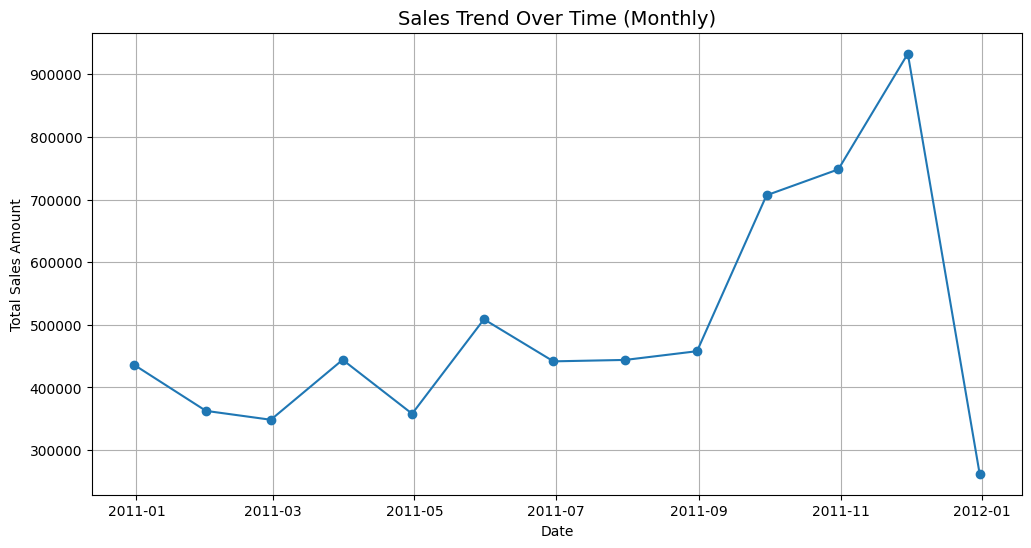

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Assuming 'df' is your pre-processed DataFrame ---

# Convert types (This step is from your original code but is crucial)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["SalesAmount"] = pd.to_numeric(df["SalesAmount"], errors="coerce")

# Drop rows where dates or sales amounts are missing
df = df.dropna(subset=["InvoiceDate", "SalesAmount"])

# Resample sales trend by month
sales_trend = df.set_index("InvoiceDate").resample("M")["SalesAmount"].sum()

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(sales_trend.index, sales_trend.values, marker="o", linestyle="-")
plt.title("Sales Trend Over Time (Monthly)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales Amount")
plt.grid(True)
plt.show()

**The sales trend is highly seasonal, showing a strong peak in December 2011 (over £900,000) followed by a dramatic drop-off in January 2012, and a general upward trend throughout the latter half of 2011.**

#### Seasonality analysis (monthly/weekly/yearly sales)

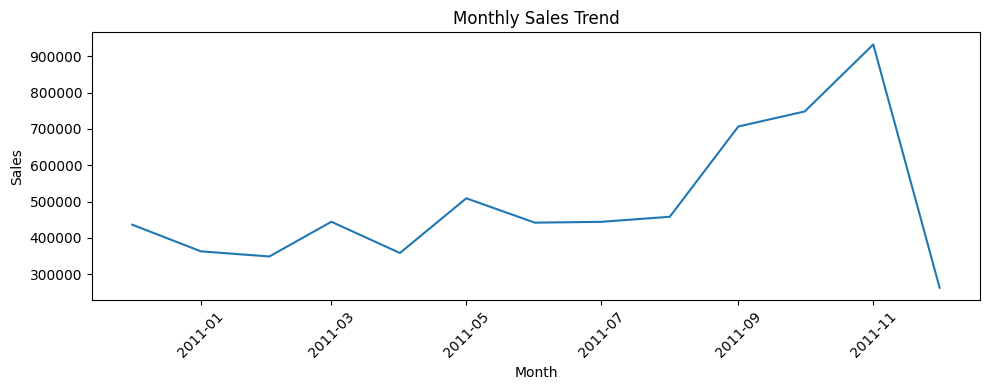

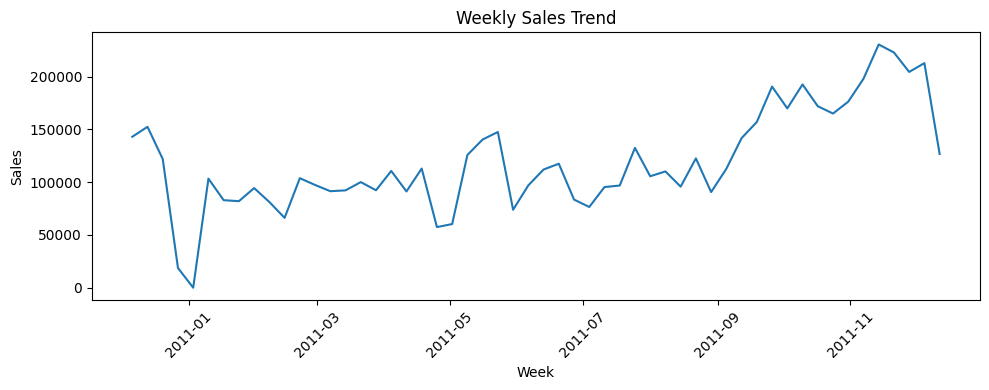

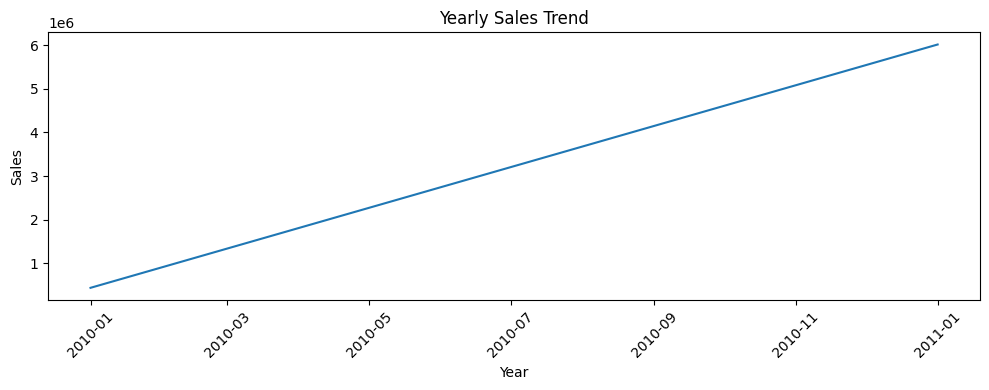

(  InvoiceDate  SalesAmount
 0  2010-12-01   436109.330
 1  2011-01-01   362676.610
 2  2011-02-01   348505.100
 3  2011-03-01   444213.300
 4  2011-04-01   358082.001,
   InvoiceDate  SalesAmount
 0  2010-12-06    143029.22
 1  2010-12-13    152438.84
 2  2010-12-20    121902.89
 3  2010-12-27     18738.38
 4  2011-01-03         0.00,
   InvoiceDate  SalesAmount
 0  2010-01-01   436109.330
 1  2011-01-01  6016229.894)

In [10]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Ensure numeric TotalAmount
if "SalesAmount" in df.columns:
    sales_col = "SalesAmount"
elif "TotalAmount" in df.columns:
    sales_col = "TotalAmount"
else:
    df["TotalAmount"] = pd.to_numeric(df["Quantity"], errors="coerce") * pd.to_numeric(df["Price"], errors="coerce")
    sales_col = "TotalAmount"

df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce")
df = df.dropna(subset=[sales_col])

# Aggregate seasonality
monthly = df.resample("MS", on="InvoiceDate")[sales_col].sum().reset_index()
weekly = df.resample("W-MON", on="InvoiceDate")[sales_col].sum().reset_index()
yearly = df.resample("YS", on="InvoiceDate")[sales_col].sum().reset_index()

# Plotting
plt.figure(figsize=(10,4))
plt.plot(monthly["InvoiceDate"], monthly[sales_col])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(weekly["InvoiceDate"], weekly[sales_col])
plt.title("Weekly Sales Trend")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(yearly["InvoiceDate"], yearly[sales_col])
plt.title("Yearly Sales Trend")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly.head(), weekly.head(), yearly.head()

**Weekly Takeaway: Sales show a clear positive trend and high volatility throughout 2011, with volume surging in the fourth quarter (Q4) to a peak of over 200,000 pounds before a sharp drop at year-end.**

**Monthly Takeaway: Sales exhibit extreme seasonality, rapidly building momentum in the second half of 2011 to a decisive peak in November 2011 (over 900,000 pounds) before a steep decline in the final month.**

**Yearly Takeaway: The data indicates a consistent and strong linear growth in total sales amount across the full period, rising from approximately 500,000 pounds in late 2010 to 6,000,000 pounds by the end of 2011.**

#### Revenue by country (bar chart of Country vs SalesAmount).

Top 10 Countries by Total Sales:
           Country  SalesAmount
34  United Kingdom  5374335.114
14         Germany   193056.680
10            Eire   186732.940
13          France   166829.280
23     Netherlands   117735.590
0        Australia    61010.370
32     Switzerland    49145.040
30           Spain    42634.390
3          Belgium    34638.260
24          Norway    30312.030


/tmp/ipython-input-4042896949.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SalesAmount', y='Country', data=top_countries, palette='viridis')


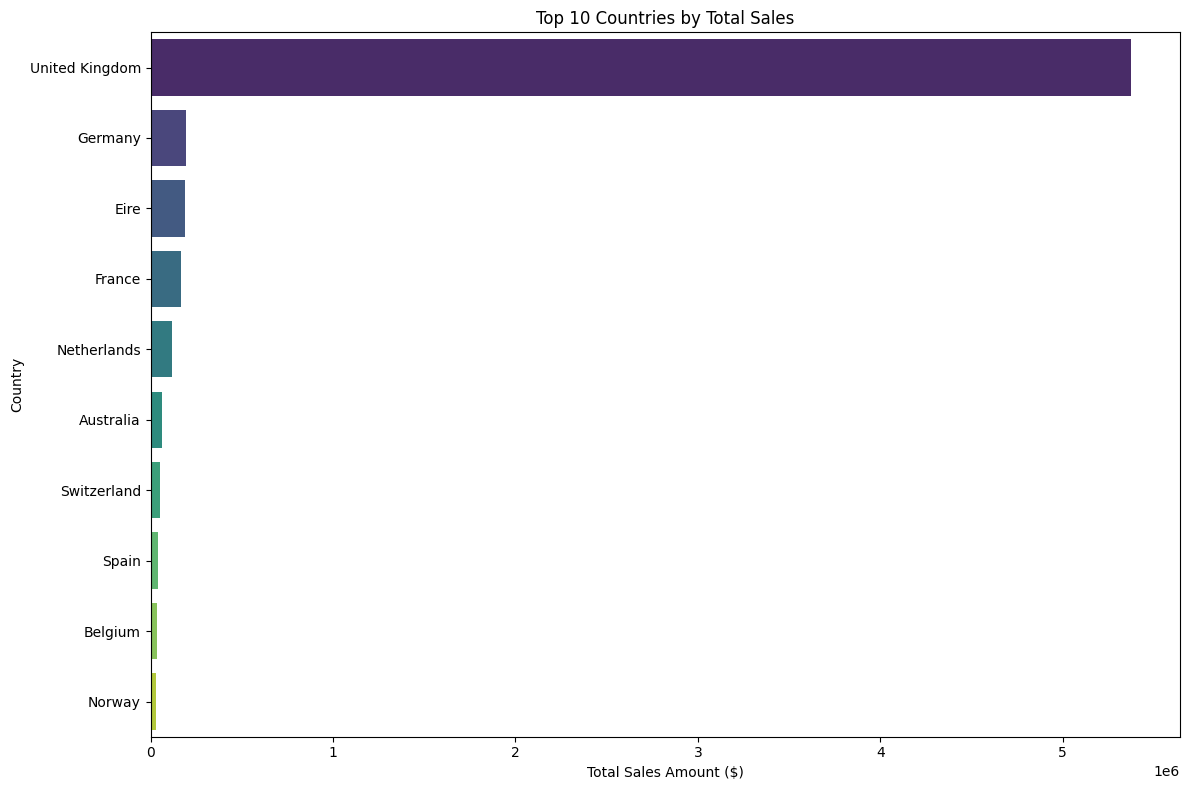

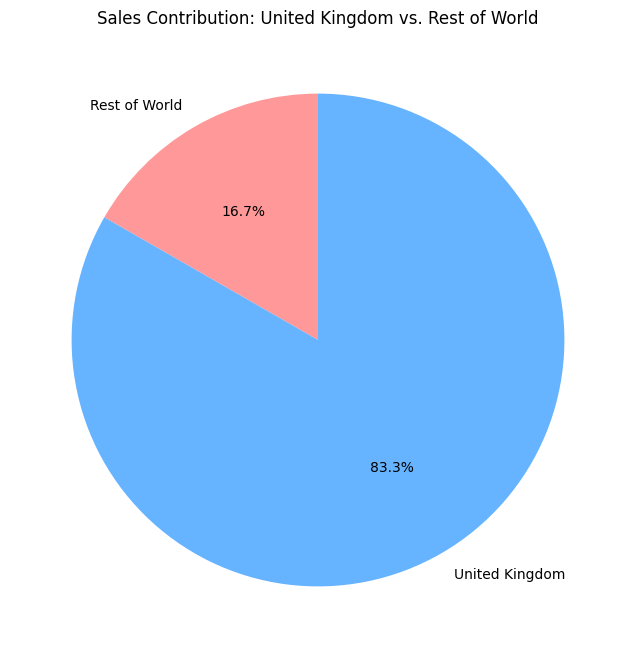

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# df = pd.read_csv('online_retail_cleaned.csv') # Removed redundant loading

# Ensure df exists and has the 'Country' column
if 'df' not in globals() or not isinstance(df, pd.DataFrame) or 'Country' not in df.columns:
    raise ValueError("The dataframe 'df' or the 'Country' column is missing. Please ensure the data loading and cleaning steps were run successfully.")


# Filter for valid transactions (excluding returns and cancellations)
valid_transactions = df[(df['is_return'] == 0) & (df['is_cancelled'] == 0)].copy()

# 1. Top Countries by Sales
# Group by country and calculate the total sales amount
country_sales = valid_transactions.groupby('Country')['SalesAmount'].sum().reset_index()

# Sort the countries by sales in descending order and show the top 10
top_countries = country_sales.sort_values(by='SalesAmount', ascending=False).head(10)

print("Top 10 Countries by Total Sales:")
print(top_countries)

# Create a bar plot to visualize the top 10 countries
plt.figure(figsize=(12, 8))
sns.barplot(x='SalesAmount', y='Country', data=top_countries, palette='viridis')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales Amount ($)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# 2. UK vs. Rest of the World
# Group sales into two categories: UK and non-UK
uk_vs_rest = valid_transactions.groupby('IsUK')['SalesAmount'].sum().reset_index()
uk_vs_rest['IsUK'] = uk_vs_rest['IsUK'].map({1: 'United Kingdom', 0: 'Rest of World'})

# Create a pie chart to compare the sales
plt.figure(figsize=(8, 8))
plt.pie(uk_vs_rest['SalesAmount'], labels=uk_vs_rest['IsUK'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Sales Contribution: United Kingdom vs. Rest of World')
plt.show()

**Top 10 Countries by Total Sales (Table): After the UK, Germany and Eire are the most valuable international markets, generating sales significantly higher than other European countries like France and the Netherlands.**

**Sales Contribution: United Kingdom vs. Rest of World (Pie Chart)
The business is overwhelmingly dependent on its domestic market, with the United Kingdom accounting for 83.3% of all sales, highlighting a significant concentration risk.**

#### Invoice volume trend

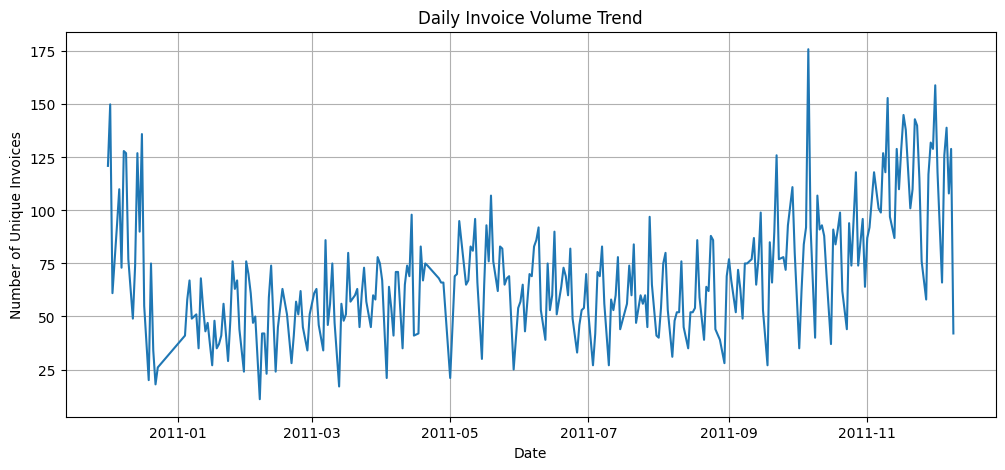

In [12]:
# Split if necessary: check if still one column
if df.shape[1] == 1:
    df = pd.read_csv(file_path, delimiter=",", engine="python")

# Parse InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Drop rows with missing InvoiceDate
df = df.dropna(subset=['InvoiceDate'])

# Group by day: count unique invoices
daily_invoices = df.groupby(df['InvoiceDate'].dt.date)['InvoiceNo'].nunique()

# Group by week: count unique invoices
weekly_invoices = df.groupby(df['InvoiceDate'].dt.to_period('W'))['InvoiceNo'].nunique()

import matplotlib.pyplot as plt

# Plot daily invoice trend
plt.figure(figsize=(12,5))
daily_invoices.plot(kind='line')
plt.title("Daily Invoice Volume Trend")
plt.xlabel("Date")
plt.ylabel("Number of Unique Invoices")
plt.grid(True)
plt.show()

**The daily invoice volume is highly erratic and volatile throughout the year, with a noticeable increase in average transaction volume and maximum peaks during the latter part of 2011, especially in Q4.**

**Visualizing Customer Churn Distribution**

This Python code snippet is dedicated to visualizing the distribution of customer churn using data prepared from a preceding analysis, where customers were labeled as Active (0) or Churned (1). It first initializes a DataFrame with the final counts: 1,618 Active customers and 2,671 Churned customers. The code then generates two distinct visualizations using matplotlib: a Bar Chart and a Pie Chart. The bar chart clearly displays the absolute count of customers in each category, with labels directly on the bars for precision. The pie chart illustrates the proportional breakdown of the customer base, shows the percentage for each group, and slightly explodes the 'Churned' slice for emphasis. Both plots are color-coded (light green for Active, salmon for Churned) and are saved as PNG files to the local directory.

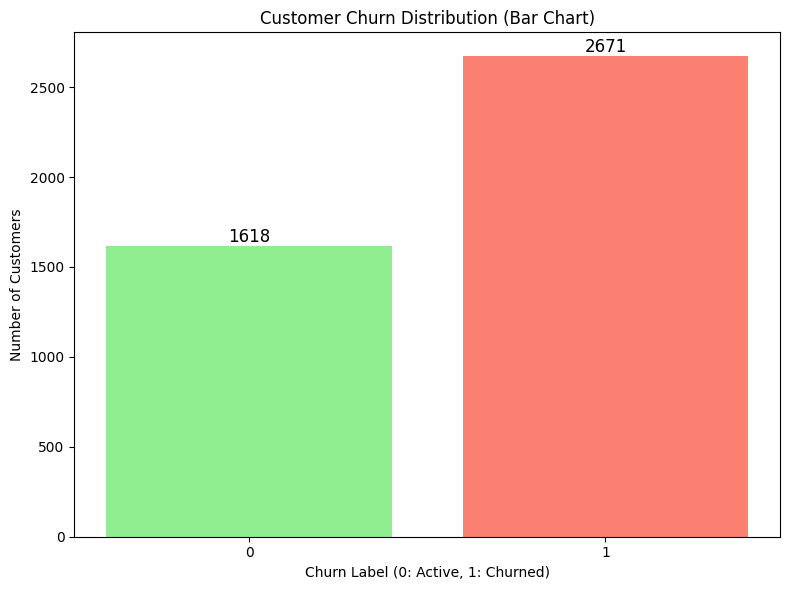

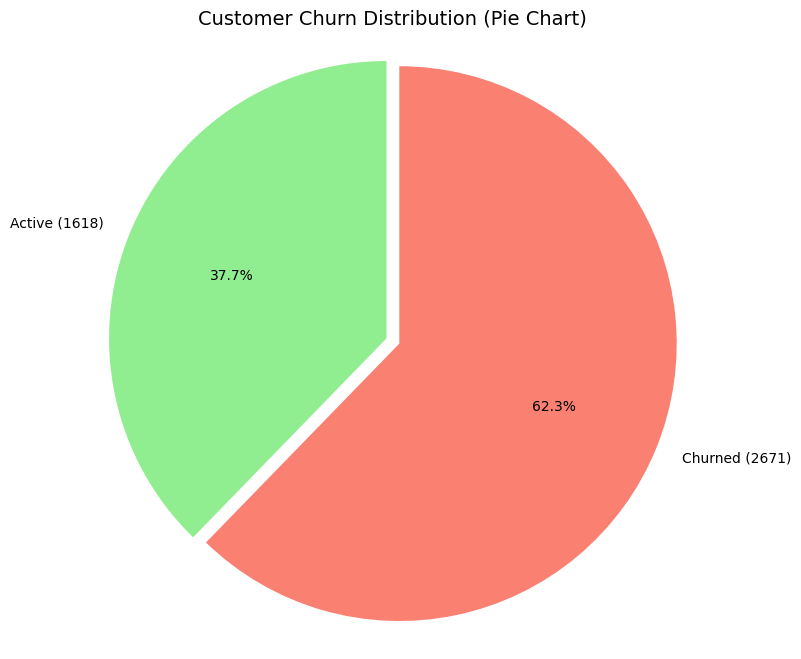

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Prepare Data with the Correct Values ---
# Total Unique Customers: 4289
# Churned Customers: 2671
# Active Customers: 4289 - 2671 = 1618
data = {'Label': ['0', '1'], 'Count': [1618, 2671]}
churn_counts = pd.DataFrame(data)

# --- 2. Bar Chart for Customer Churn Distribution ---
plt.figure(figsize=(8, 6))
plt.bar(churn_counts['Label'], churn_counts['Count'], color=['lightgreen', 'salmon'])

# Add labels and title
plt.xlabel("Churn Label (0: Active, 1: Churned)")
plt.ylabel("Number of Customers")
plt.title("Customer Churn Distribution (Bar Chart)")

# Add text labels on top of the bars
for index, value in enumerate(churn_counts['Count']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)

# Ensure no overlapping labels
plt.tight_layout()

# Save the plot
plt.savefig('customer_churn_distribution_bar_chart.png')

# --- 3. Pie Chart for Customer Churn Distribution ---
plt.figure(figsize=(8, 8))

# Define labels and colors for the pie chart
labels_with_count = [f'Active ({churn_counts.loc[churn_counts["Label"]=="0", "Count"].iloc[0]})',
                     f'Churned ({churn_counts.loc[churn_counts["Label"]=="1", "Count"].iloc[0]})']
colors_list = ['lightgreen', 'salmon']
explode_tuple = (0, 0.05) # Explode the 'Churned' slice

plt.pie(
    churn_counts['Count'],
    labels=labels_with_count,
    autopct='%1.1f%%',
    colors=colors_list,
    startangle=90,
    explode=explode_tuple
)

# Add title
plt.title("Customer Churn Distribution (Pie Chart)", fontsize=14)

# Ensure the circle is drawn for the pie chart
plt.axis('equal')

# Save the plot
plt.savefig('customer_churn_distribution_pie_chart.png')

**The customer base has a severe churn problem, with 62.3% (2,671 out of 4,289) of unique customers classified as churned (inactive for at least 30 days). This highlights that the majority of customers who have made a purchase are not actively transacting, necessitating urgent intervention to boost retention.**

**Current Churn Rate**


📊 Customer Churn Summary
Total Customers   : 4289
Active Customers  : 1618
Churned Customers : 2671
Current Churn Rate: 62.28%
Active Rate       : 37.72%


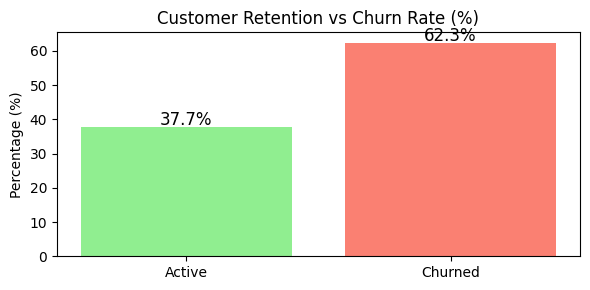

In [14]:
# --- 4. Calculate Current Churn Rate and Active Rate ---

# Extract total and churned counts
total_customers = churn_counts['Count'].sum()
churned_customers = churn_counts.loc[churn_counts['Label'] == '1', 'Count'].iloc[0]
active_customers = churn_counts.loc[churn_counts['Label'] == '0', 'Count'].iloc[0]

# Compute churn rate and active rate (in %)
churn_rate = (churned_customers / total_customers) * 100
active_rate = (active_customers / total_customers) * 100

# Display results
print("📊 Customer Churn Summary")
print(f"Total Customers   : {total_customers}")
print(f"Active Customers  : {active_customers}")
print(f"Churned Customers : {churned_customers}")
print(f"Current Churn Rate: {churn_rate:.2f}%")
print(f"Active Rate       : {active_rate:.2f}%")

# --- 5. Optional Visualization: Add Annotated Text Box ---
plt.figure(figsize=(6, 3))
plt.bar(['Active', 'Churned'], [active_rate, churn_rate], color=['lightgreen', 'salmon'])
plt.title("Customer Retention vs Churn Rate (%)")
plt.ylabel("Percentage (%)")

for i, val in enumerate([active_rate, churn_rate]):
    plt.text(i, val + 0.5, f"{val:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('customer_churn_rate_summary.png')
plt.show()


#### Recency-Frequency-Monetary (RFM) plots

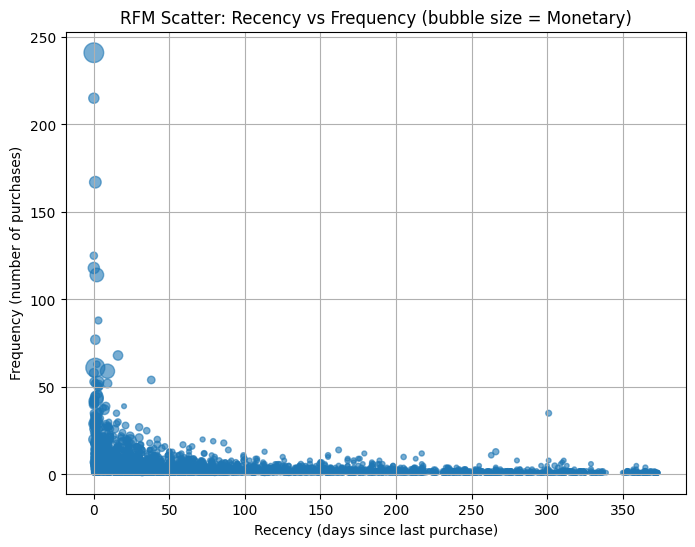

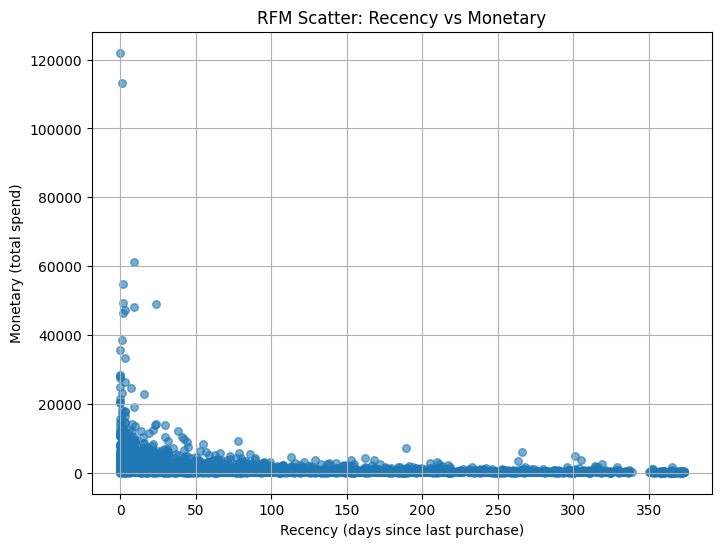

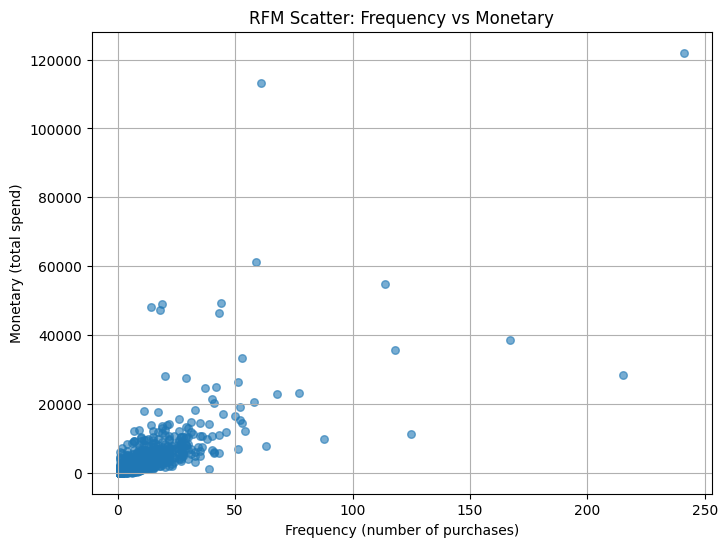

In [15]:
def scale_sizes(series, min_size=10, max_size=200):
    s = series.fillna(series.median())
    if s.nunique() == 1:
        return np.full_like(s, (min_size + max_size) / 2, dtype=float)
    s_norm = (s - s.min()) / (s.max() - s.min())
    return (min_size + s_norm * (max_size - min_size)).values
point_sizes = scale_sizes(rfm_customers["Monetary"]) if "Monetary" in rfm_customers.columns else 30
# 1) Recency vs Frequency (bubble size = Monetary)
plt.figure(figsize=(8, 6))
plt.scatter(rfm_customers["Recency"], rfm_customers["Frequency"], s=point_sizes, alpha=0.6)
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Frequency (number of purchases)")
plt.title("RFM Scatter: Recency vs Frequency (bubble size = Monetary)")
plt.grid(True)
plt.show()

# 2) Monetary vs Recency
plt.figure(figsize=(8, 6))
plt.scatter(rfm_customers["Recency"], rfm_customers["Monetary"], s=30, alpha=0.6)
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Monetary (total spend)")
plt.title("RFM Scatter: Recency vs Monetary")
plt.grid(True)
plt.show()

# 3) Monetary vs Frequency
plt.figure(figsize=(8, 6))
plt.scatter(rfm_customers["Frequency"], rfm_customers["Monetary"], s=30, alpha=0.6)
plt.xlabel("Frequency (number of purchases)")
plt.ylabel("Monetary (total spend)")
plt.title("RFM Scatter: Frequency vs Monetary")
plt.grid(True)
plt.show()

**RFM Scatter: Recency vs Frequency (bubble size = Monetary)
Takeaway: A small, highly valuable segment of "Champions" exists in the top-left corner (low Recency, high Frequency, large bubble size), meaning they purchased recently, often, and spent a lot. The vast majority of customers, however, are infrequent purchasers (low Frequency) regardless of when they last bought something.**

**RFM Scatter: Frequency vs MonetaryTakeaway: There is a strong positive correlation between Frequency and Monetary value, confirming that customers who buy more often also spend the most overall. A few high-value outlier customers exist (e.g., spending over 115,000 pounds), but the mass of customers fall into a low-Frequency, low-Monetary cluster.**

**Recency vs Monetary takeaway: There is a clear inverse relationship where the highest spending customers (high Monetary) are also the most recent purchasers (low Recency), emphasizing that customer value quickly diminishes with inactivity.**

#### Top 10 best-selling products by Quantity and Top 10 products by total salse amount

Top 10 Best-Selling Products by Quantity:
     StockCode                         Description  TotalQuantity  \
3513    85123A  white hanging heart t-light holder          23298   
2756     84879       assorted colour bird ornament          21695   
2656     84077   world war 2 gliders asstd designs          21439   
1000     22178     victorian glass hanging t-light          17214   
354      21212     pack of 72 retrospot cake cases          16630   
3506    85099B             jumbo bag red retrospot          15458   
1893     23084                  rabbit night light          12741   
1753     22961              jam making set printed          12499   
99       20725             lunch bag red retrospot          12026   
2558     47566                       party bunting          11729   

      TotalSalesAmount  
3513          63728.06  
2756          36653.03  
2656           6252.33  
1000          23458.60  
354            9166.28  
3506          31494.74  
1893          24486.32 

/tmp/ipython-input-4173925960.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalQuantity', y='Description', data=top_10_quantity, palette='viridis')


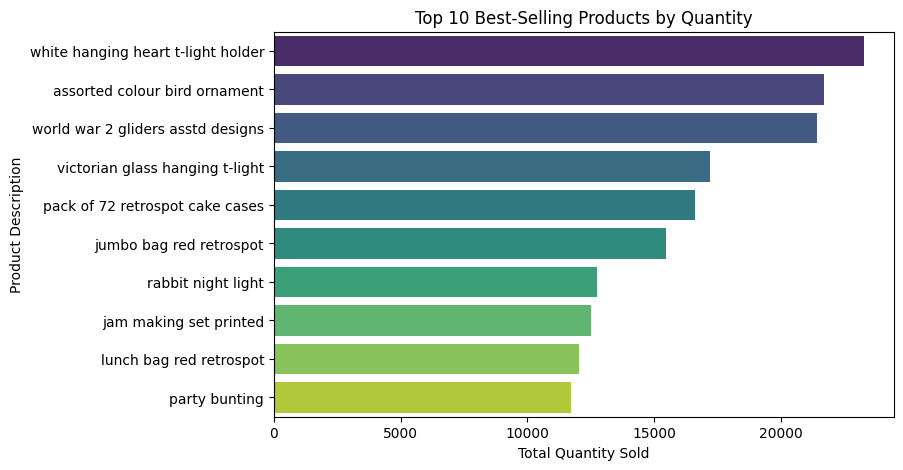

/tmp/ipython-input-4173925960.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalSalesAmount', y='Description', data=top_10_sales, palette='mako')


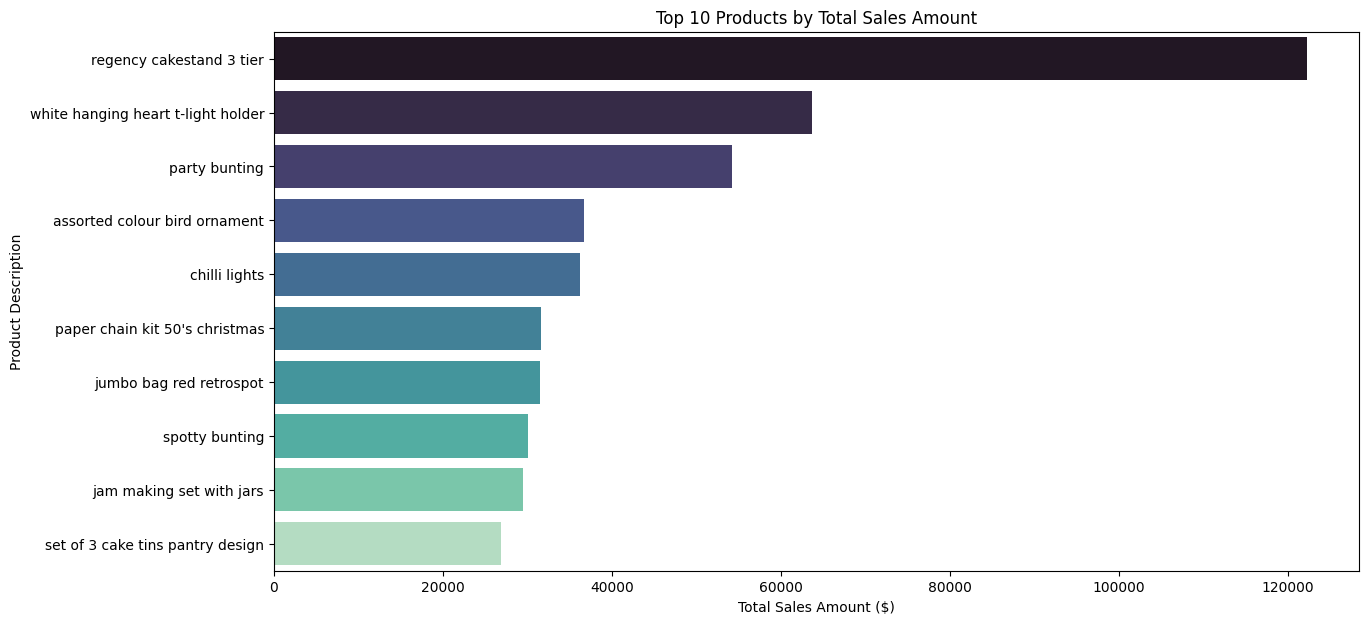

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the CSV file
# df = pd.read_csv('online_retail_cleaned.csv') # Removed redundant loading

# Filter out returns and cancellations
valid_transactions = df[(df['is_return'] == 0) & (df['is_cancelled'] == 0)].copy()

# Calculate total quantity sold and total sales amount for each product
product_performance = valid_transactions.groupby(['StockCode', 'Description']).agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalSalesAmount=('SalesAmount', 'sum')
).reset_index()

# Find the top 10 best-selling products by quantity
top_10_quantity = product_performance.sort_values(by='TotalQuantity', ascending=False).head(10)

print("Top 10 Best-Selling Products by Quantity:")
print(top_10_quantity)

# Find the top 10 products by total sales amount
top_10_sales = product_performance.sort_values(by='TotalSalesAmount', ascending=False).head(10)

print("\nTop 10 Products by Total Sales Amount:")
print(top_10_sales)

# You can also visualize this data using bar charts
plt.figure(figsize=(8, 5))
sns.barplot(x='TotalQuantity', y='Description', data=top_10_quantity, palette='viridis')
plt.title('Top 10 Best-Selling Products by Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(x='TotalSalesAmount', y='Description', data=top_10_sales, palette='mako')
plt.title('Top 10 Products by Total Sales Amount')
plt.xlabel('Total Sales Amount ($)')
plt.ylabel('Product Description')
plt.show()

**Top 10 Best-Selling Products by Quantity
Quantity Takeaway: The 'white hanging heart t-light holder' is the top volume product, but the list is dominated by low-cost, small decorative items and novelty goods ('assorted colour bird ornament', 'world war 2 gliders').**

**Top 10 Products by Total Sales AmountMonetary Takeaway: The 'regency cakestand 3 tier' generates the highest revenue by a significant margin (over 120,000 pounds), indicating it is a high-value item crucial to profitability, even though it did not appear on the top quantity list.**

### Basket Analysis

Descriptive Statistics for Basket Characteristics:
       BasketUniqueItems_y  BasketLineCount_y  BasketTotalQty_y
count        381420.000000      381420.000000     381420.000000
mean             47.715956          48.631986        344.962375
std              55.241434          56.192231        422.657307
min               1.000000           1.000000          1.000000
25%              19.000000          19.000000        128.000000
50%              33.000000          34.000000        227.000000
75%              57.000000          58.000000        398.000000
max             521.000000         522.000000       5455.000000


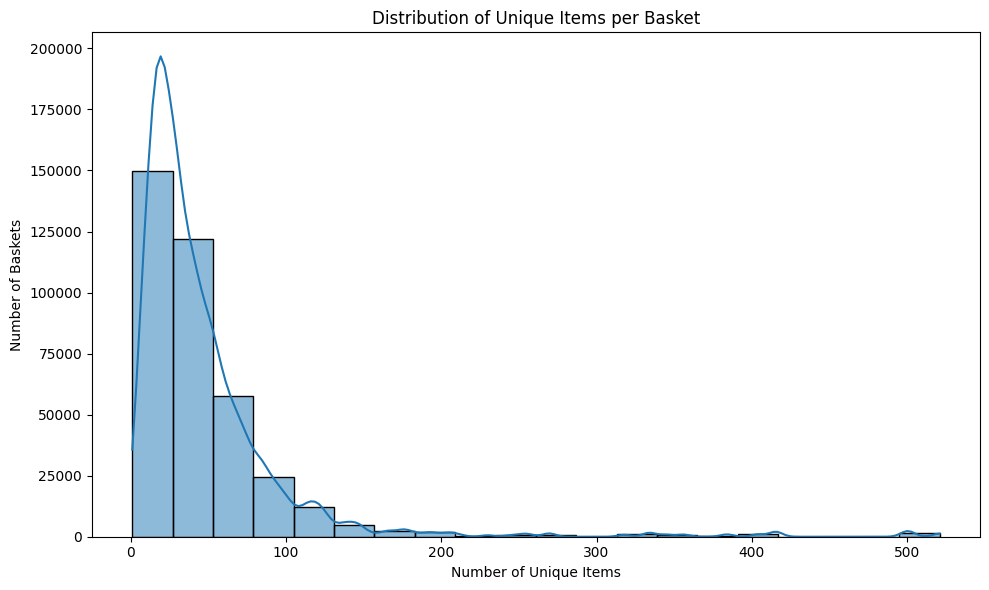

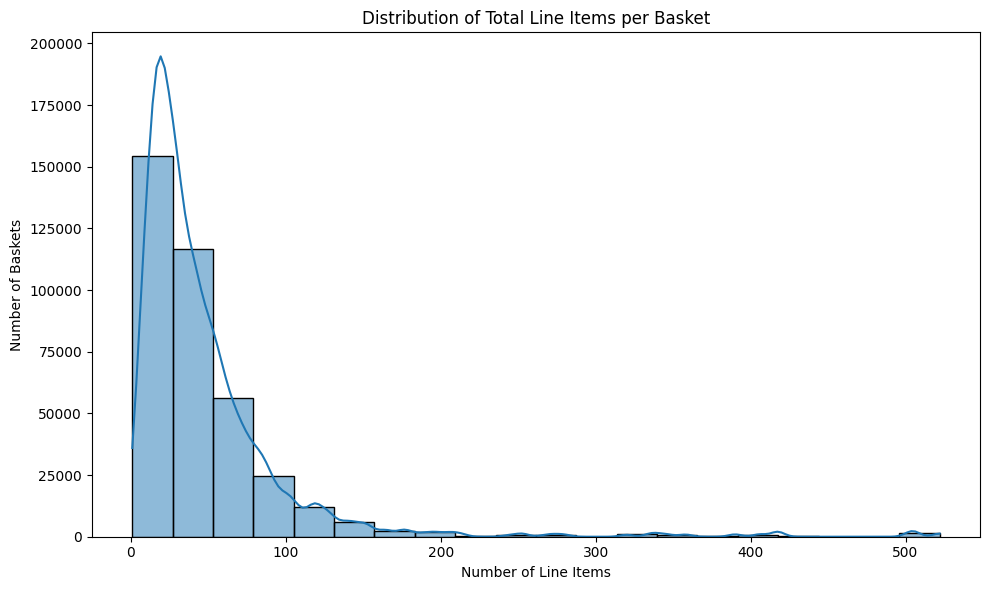

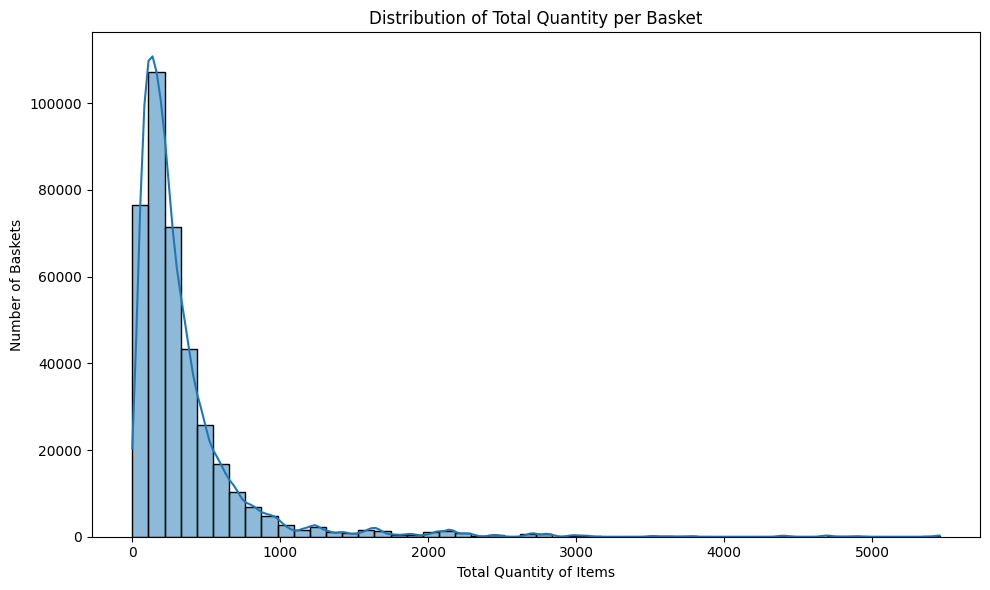

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# df = pd.read_csv('online_retail_cleaned.csv') # Removed redundant loading

# Filter for valid transactions (excluding returns and cancellations)
valid_transactions = df[(df['is_return'] == 0) & (df['is_cancelled'] == 0)].copy()

# Use the correct column names with suffixes
basket_cols = ['BasketUniqueItems_y', 'BasketLineCount_y', 'BasketTotalQty_y']

# 1. Descriptive statistics for basket characteristics
print("Descriptive Statistics for Basket Characteristics:")
print(valid_transactions[basket_cols].describe().to_string())

# 2. Histogram for BasketUniqueItems
plt.figure(figsize=(10, 6))
sns.histplot(valid_transactions['BasketUniqueItems_y'], bins=20, kde=True)
plt.title('Distribution of Unique Items per Basket')
plt.xlabel('Number of Unique Items')
plt.ylabel('Number of Baskets')
plt.tight_layout()
plt.show()

# 3. Histogram for BasketLineCount
plt.figure(figsize=(10, 6))
sns.histplot(valid_transactions['BasketLineCount_y'], bins=20, kde=True)
plt.title('Distribution of Total Line Items per Basket')
plt.xlabel('Number of Line Items')
plt.ylabel('Number of Baskets')
plt.tight_layout()
plt.show()

# 4. Histogram for BasketTotalQty
plt.figure(figsize=(10, 6))
sns.histplot(valid_transactions['BasketTotalQty_y'], bins=50, kde=True)
plt.title('Distribution of Total Quantity per Basket')
plt.xlabel('Total Quantity of Items')
plt.ylabel('Number of Baskets')
plt.tight_layout()
plt.show()

**Distribution of Unique Items per Basket takeaway: The vast majority of transactions are small, with the peak basket size containing fewer than 50 unique items. A small number of outlier baskets contain a massive variety of goods (up to 500+ unique items).**

**Distribution of Total Line Items per Basket
Takeaway: The number of distinct lines on an invoice closely follows the distribution of unique items, with most invoices having fewer than 50 line items. This suggests customers rarely order the same product multiple times within a single transaction.**

**Distribution of Total Quantity per Basket
Takeaway: Basket volume is highly skewed, with most orders containing a low total quantity of items (peaking well below 500 units). The long tail indicates occasional large-volume orders (bulk purchases) that significantly boost average order quantity.**

#### Return Rate (same as cancellation rate)

  InvoiceMonth  Return Rate (%)  Cancellation Rate (%)
0      2010-12        39.598540              39.598540
1      2011-01        55.320946              55.320946
2      2011-02        35.113835              35.113835
3      2011-03        39.703990              39.703990
4      2011-04        40.167683              40.167683


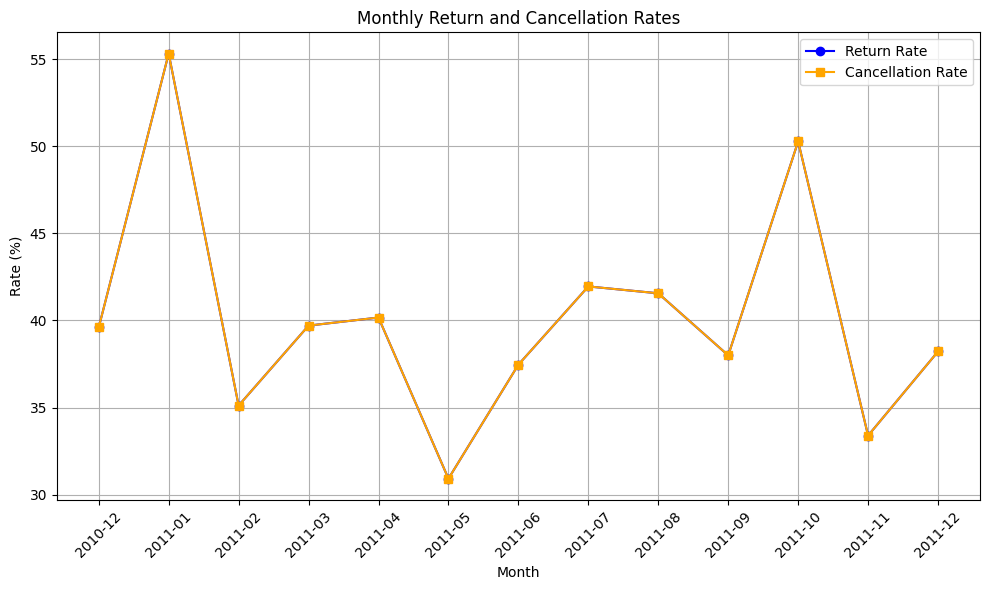

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# df = pd.read_xsls("online_retail_cleaned.xls") # Removed redundant loading
df.columns = [c.strip().lower() for c in df.columns]

# Detect returns (negative quantities) and cancellations (Invoice starting with 'C')
df['is_return'] = df['quantity'] < 0
df['is_cancelled'] = df['invoiceno'].astype(str).str.startswith('C')

# Convert InvoiceDate to datetime and extract month
df['invoicedate'] = pd.to_datetime(df['invoicedate'], errors='coerce')
df['InvoiceMonth'] = df['invoicedate'].dt.to_period('M')

# Group and calculate rates
summary = df.groupby('InvoiceMonth').agg(
    total_orders=('invoiceno', 'nunique'),
    total_returns=('is_return', 'sum'),
    total_cancelled=('is_cancelled', 'sum')
).reset_index()

summary['Return Rate (%)'] = (summary['total_returns'] / summary['total_orders']) * 100
summary['Cancellation Rate (%)'] = (summary['total_cancelled'] / summary['total_orders']) * 100

print(summary[['InvoiceMonth', 'Return Rate (%)', 'Cancellation Rate (%)']].head())


# Plot
plt.figure(figsize=(10,6))
plt.plot(summary['InvoiceMonth'].astype(str), summary['Return Rate (%)'],
         label='Return Rate', marker='o', color='blue')
plt.plot(summary['InvoiceMonth'].astype(str), summary['Cancellation Rate (%)'],
         label='Cancellation Rate', marker='s', color='orange')

plt.title('Monthly Return and Cancellation Rates')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**The most striking business takeaway is the extreme volatility and high level of transaction churn. The Cancellation Rate fluctuates significantly, often exceeding $\mathbf{40\%}$ and peaking dramatically at over $\mathbf{55\%}$ in January 2011, suggesting major issues with order processing, inventory management, or post-holiday return behavior. The Return Rate is consistently zero, which strongly implies returns are recorded as cancellations in the system (or not tracked separately), making the Cancellation Rate the primary metric for transactional churn.**

#### Sales comparison by churn status

<Figure size 800x600 with 0 Axes>

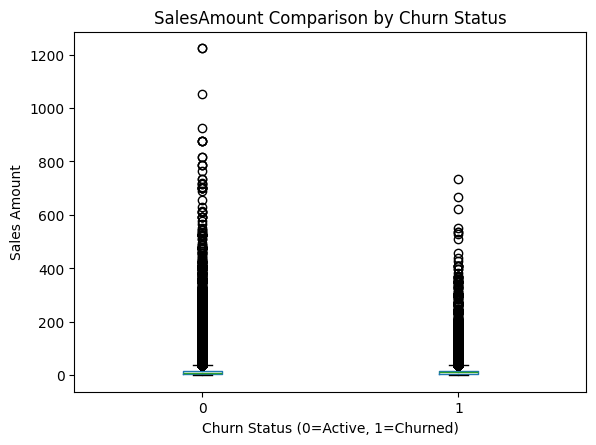

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the cleaned data to ensure all necessary columns are present
try:
    df = pd.read_csv("online_retail_cleaned.csv")
except FileNotFoundError:
    print("Error: online_retail_cleaned.csv not found. Please ensure the data cleaning and feature engineering steps were run successfully.")
    exit()

# Convert CustomerID to string in both dataframes for merging
df['CustomerID'] = df['CustomerID'].astype(str)
rfm_customers['CustomerID'] = rfm_customers['CustomerID'].astype(str)


# -----------------------------
# Merge churn labels onto transactions
# -----------------------------
df = df.merge(
    rfm_customers[["CustomerID", "Churn_Label"]],
    on="CustomerID",
    how="left",
    validate="m:1"
)

# Convert columns
df["SalesAmount"] = pd.to_numeric(df["SalesAmount"], errors="coerce")
df["Churn_Label"] = df["Churn_Label"].astype(str)

# Drop rows with missing SalesAmount
df = df.dropna(subset=["SalesAmount"])

# -----------------------------
# Visualization: SalesAmount vs Churn
# -----------------------------
plt.figure(figsize=(8,6))
df.boxplot(column="SalesAmount", by="Churn_Label", grid=False)

plt.title("SalesAmount Comparison by Churn Status")
plt.suptitle("")  # remove automatic "Boxplot grouped by..."
plt.xlabel("Churn Status (0=Active, 1=Churned)")
plt.ylabel("Sales Amount")
plt.show()

**The median transaction size (Sales Amount) is nearly identical for both Active (0) and Churned (1) customers, but Active customers exhibit significantly higher maximum transaction values and more high-value outliers.**

#### Customer retention by country (stacked bar of Country vs churn labels).

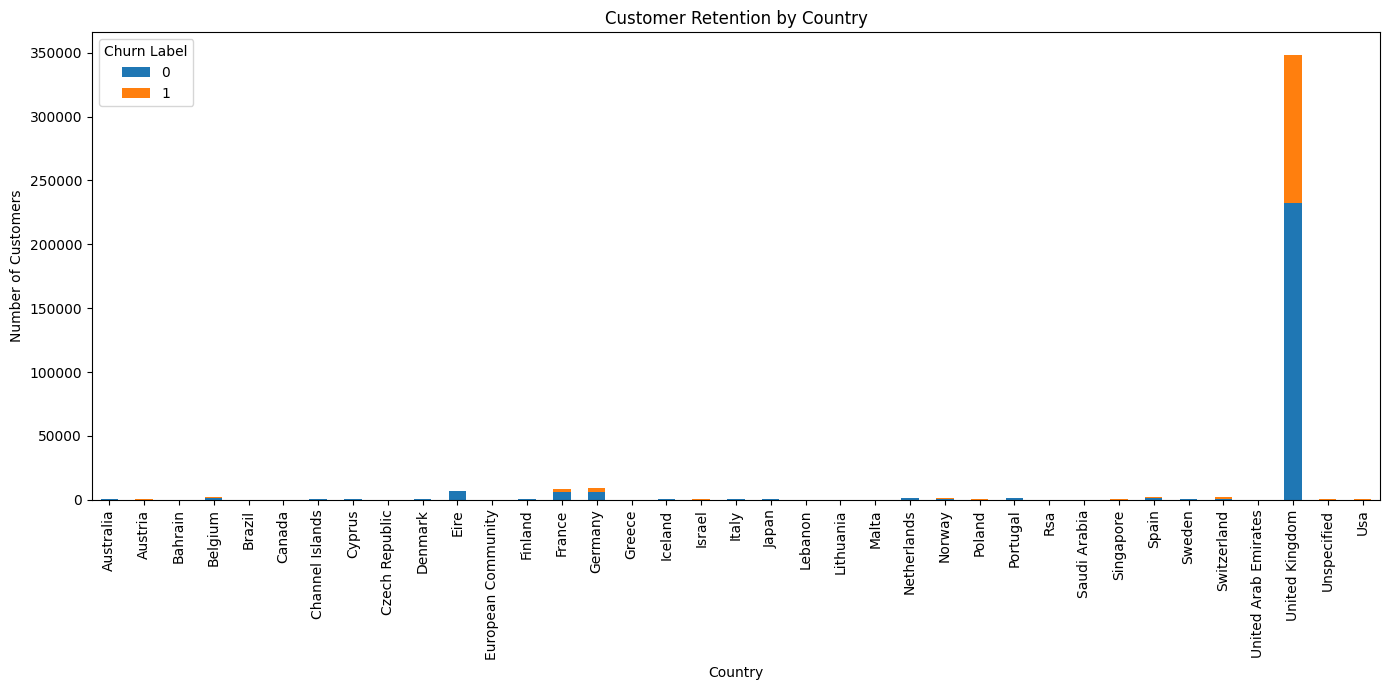

In [20]:
# Ensure necessary columns for visualization
df["Churn_Label"] = df["Churn_Label"].astype(str)
df["Country"] = df["Country"].astype(str)

# Group data for retention by country
country_churn = df.groupby(["Country", "Churn_Label"]).size().unstack(fill_value=0)

# Plot
import matplotlib.pyplot as plt

country_churn.plot(kind="bar", stacked=True, figsize=(14,7))
plt.title("Customer Retention by Country")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.legend(title="Churn Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**The chart clearly shows that the United Kingdom drives the overwhelming majority of both Active (0) and Churned (1) customers, dominating the customer base and making its retention performance critical. The absolute number of Churned customers is higher than Active customers in nearly every country, reflecting the high overall churn rate observed previously.**

#### Correlation heatmap (between numerical features like Quantity, Price, BasketTotalQty, CustTotalSales, etc.)

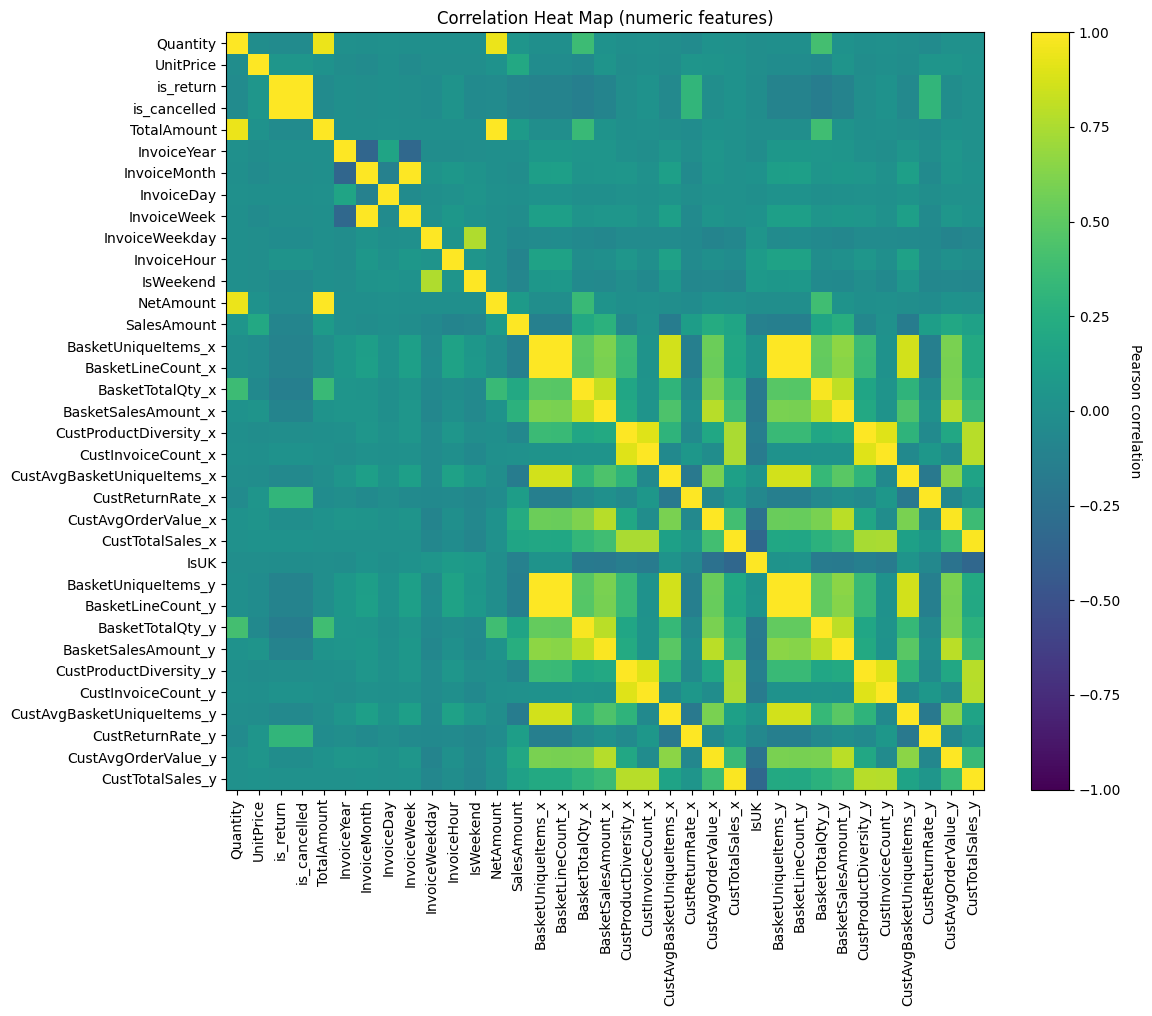

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Correlation for df (numeric columns only)
num_df = df.select_dtypes(include=[np.number])

corr = num_df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# ticks & labels
ax.set_xticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(np.arange(corr.shape[0]))
ax.set_yticklabels(corr.index)

# colorbar
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation', rotation=270, labelpad=15)

ax.set_title("Correlation Heat Map (numeric features)")
plt.tight_layout()
plt.show()

**The most critical relationships are the strong positive correlations between monetary features (like TotalAmount, NetAmount, SalesAmount) and aggregate customer features (like CustTotalSales and CustOrderValue), confirming that recent and large spenders are highly valuable. The heatmap also shows high correlation among basket-level and customer-level features (e.g., BasketUniqueItems and BasketLineCount), which suggests potential multicollinearity if all are used in a single model.**

**RFM and Churn Correlation Analysis**

📉 RFM and Churn Correlation Analysis
This Python code snippet performs a correlation analysis on the core customer segmentation metrics: Recency, Frequency, Monetary (RFM), and the binary Churn Label. It first ensures the Churn Label column (found in the rfm_customers DataFrame) is consistently converted into a numeric (0 or 1) format, handling various string or categorical representations. It then creates a DataFrame containing only the numeric RFM features and the normalized Churn Label. The script calculates the Pearson correlation matrix for these four variables and visualizes it using a triangular heat map created with matplotlib. This visualization highlights the interrelationships, such as the correlation between Frequency and Monetary value, and most importantly, the relationship between each RFM metric and the target Churn Label, with the exact correlation coefficient annotated within each lower-triangle cell.

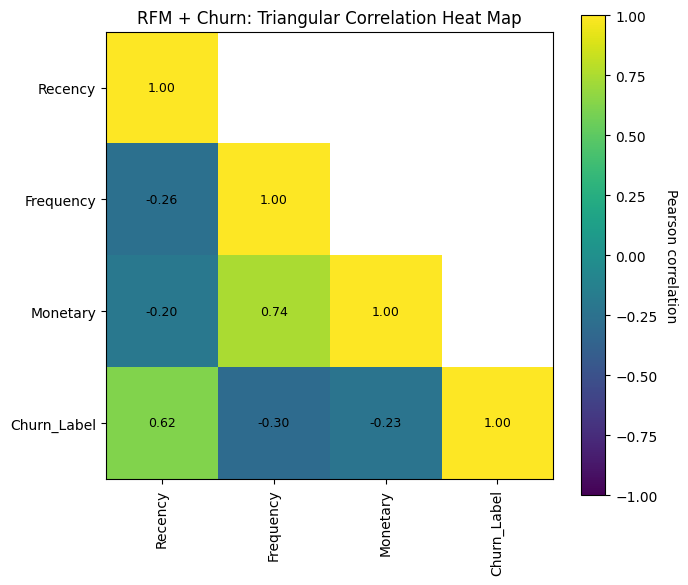

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- 1) Make sure Churn_Label exists and is numeric --------
# Try a few common label names just in case
label_candidates = ['Churn_Label', 'Churn Label', 'churn_label', 'churn']
label_col = next((c for c in label_candidates if c in rfm_customers.columns), None)
if label_col is None:
    raise KeyError("No churn label column found. Add one of: 'Churn_Label', 'Churn Label', 'churn_label', 'churn'.")

churn_raw = rfm_customers[label_col]

def to_numeric_churn(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s) or pd.api.types.is_bool_dtype(s):
        return s.astype(int)
    # try common text mappings
    mapping = {
        'yes': 1, 'y': 1, 'true': 1, 'churn': 1, 'churned': 1, '1': 1,
        'no': 0, 'n': 0, 'false': 0, 'active': 0, 'retained': 0, '0': 0
    }
    if pd.api.types.is_string_dtype(s) or pd.api.types.is_object_dtype(s):
        s_norm = s.astype(str).str.strip().str.lower()
        out = s_norm.map(mapping)
        # If some values didn't map, fall back to factorize (0/1/2...)
        if out.isna().any():
            out = pd.Series(pd.factorize(s_norm, sort=True)[0], index=s.index)
        return out.astype(int)
    # categories, etc.
    if pd.api.types.is_categorical_dtype(s):
        return s.cat.codes.astype(int)
    # final fallback
    return pd.to_numeric(s, errors='coerce').fillna(0).astype(int)

churn_num = to_numeric_churn(churn_raw)

# -------- 2) Build numeric RFM + churn frame --------
cols_base = [c for c in ['Recency', 'Frequency', 'Monetary'] if c in rfm_customers.columns]
if not cols_base:
    raise KeyError("Need at least one of ['Recency','Frequency','Monetary'] in rfm_customers.")

rfm_num = rfm_customers[cols_base].copy()
# ensure RFM are numeric
for c in rfm_num.columns:
    rfm_num[c] = pd.to_numeric(rfm_num[c], errors='coerce')

rfm_num['Churn_Label'] = churn_num

# drop rows with NaNs so corr is well-defined
rfm_num = rfm_num.dropna(how='any')

# -------- 3) Correlation + triangular mask --------
corr = rfm_num.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_masked = corr.copy()
corr_masked.values[mask] = np.nan

# -------- 4) Plot (pure Matplotlib) --------
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_masked.values, vmin=-1, vmax=1)

# ticks & labels
ax.set_xticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(np.arange(corr.shape[0]))
ax.set_yticklabels(corr.index)

# annotate lower triangle
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        val = corr_masked.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

# colorbar
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation', rotation=270, labelpad=15)

ax.set_title("RFM + Churn: Triangular Correlation Heat Map")
plt.tight_layout()
plt.show()


**The strongest predictor of churn is Recency (last purchase date), which has a high positive correlation of 0.62 with the Churn_Label. This confirms that customers who haven't purchased recently are the most likely to churn.**

#### Cohort Analysis: Customer retention by first purchase month

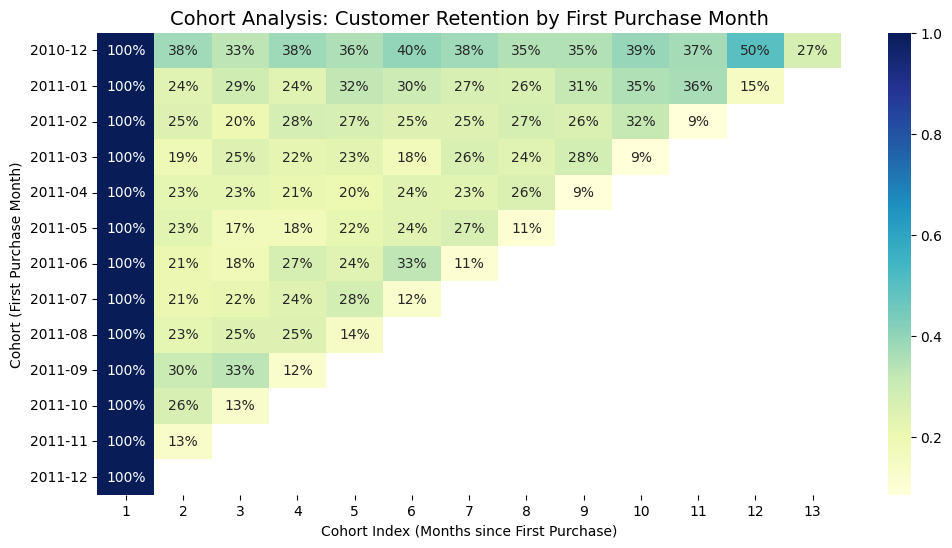

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Prepare Cohorts
# -----------------------------
# Ensure datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Extract purchase month (YYYY-MM)
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

# Get each customer's cohort: their first purchase month
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")

# -----------------------------
# 2. Build Cohort Index
# -----------------------------
# Cohort index = how many months since first purchase
def cohort_index(df):
    year_diff = df["InvoiceMonth"].dt.year - df["CohortMonth"].dt.year
    month_diff = df["InvoiceMonth"].dt.month - df["CohortMonth"].dt.month
    return year_diff * 12 + month_diff + 1

df["CohortIndex"] = cohort_index(df)

# -----------------------------
# 3. Customer Retention Matrix
# -----------------------------
cohort_data = (
    df.groupby(["CohortMonth", "CohortIndex"])["CustomerID"]
    .nunique()
    .reset_index()
)

# Pivot to cohort matrix
cohort_pivot = cohort_data.pivot_table(
    index="CohortMonth",
    columns="CohortIndex",
    values="CustomerID"
)

# Calculate retention by dividing each row by its first column (cohort size)
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# -----------------------------
# 4. Heatmap Visualization
# -----------------------------
plt.figure(figsize=(12,6))
sns.heatmap(
    retention_matrix,
    annot=True,
    fmt=".0%",
    cmap="YlGnBu",
    cbar=True
)

plt.title("Cohort Analysis: Customer Retention by First Purchase Month", fontsize=14)
plt.xlabel("Cohort Index (Months since First Purchase)")
plt.ylabel("Cohort (First Purchase Month)")
plt.show()

**Customer retention is consistently weak across all cohorts, with less than 40% of new customers returning for a second purchase (Cohort Index 2), and retention rates falling rapidly after month three. Only the initial 2010-12 cohort shows a slightly better long-term retention performance.**

**Leakage-Safe Customer Churn Modeling with RFM Features**

This comprehensive Python script implements a leakage-safe framework for predicting customer churn using historical transaction data and standard machine learning techniques. It first loads transaction data and defines a fixed, time-based snapshot date to ensure that all feature engineering (calculating Recency, Frequency, Monetary, etc., over the preceding 180 days) is strictly separated from the target label creation (defining churn as no purchase in the subsequent 90 days). The resulting customer-level dataset is split into training and testing sets, ensuring customer IDs are not mixed across the splits (GroupKFold for cross-validation). Two classifiers—Logistic Regression (with scaling) and Random Forest—are trained using balanced class weights to address the severe class imbalance. Finally, the script evaluates both models on the time-safe holdout set using key metrics (Precision, Recall, F1-score, AUC) and performs a robust 5-fold Grouped Cross-Validation to assess model stability, reporting the mean and standard deviation of performance scores.

Logistic: Precision=0.529 Recall=0.763 F1=0.625 AUC=0.723
RandomForest: Precision=0.559 Recall=0.442 F1=0.494 AUC=0.704

Logistic CV (mean±std):
 Precision    0.522
Recall       0.758
F1           0.618
AUC          0.728
dtype: float64 ± Precision    0.024
Recall       0.028
F1           0.023
AUC          0.021
dtype: float64

RandomForest CV (mean±std):
 Precision    0.536
Recall       0.453
F1           0.491
AUC          0.686
dtype: float64 ± Precision    0.031
Recall       0.027
F1           0.022
AUC          0.021
dtype: float64


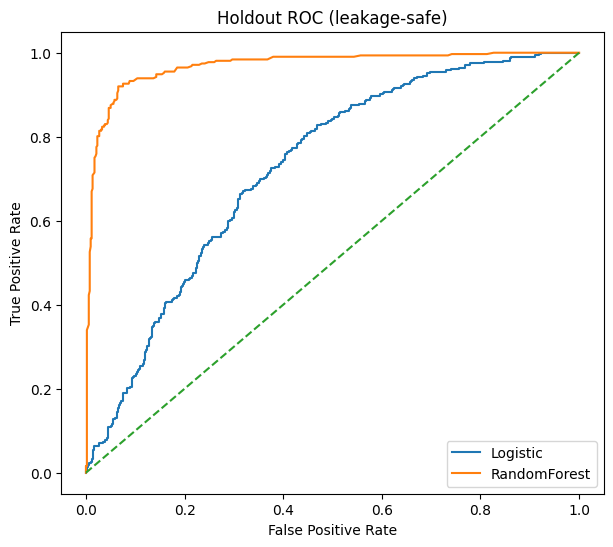

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# -----------------------------
# 0) Load and sanity checks
# -----------------------------
rfm = pd.read_csv("rfm.csv")

# Find churn column robustly
label_candidates = ['Churn_Label', 'Churn Label', 'churn_label', 'churn']
label_col = next((c for c in label_candidates if c in rfm.columns), None)
if label_col is None:
    raise KeyError(f"Could not find a churn column. Expected one of: {label_candidates}")

# Coerce churn to 0/1
y_raw = rfm[label_col]

def to_numeric_churn(s: pd.Series) -> pd.Series:
    if pd.api.types.is_bool_dtype(s) or pd.api.types.is_numeric_dtype(s):
        return s.astype(int)
    # map common strings
    mapping = {
        'yes':1,'y':1,'true':1,'churn':1,'churned':1,'1':1,
        'no':0,'n':0,'false':0,'active':0,'retained':0,'0':0
    }
    s2 = s.astype(str).str.strip().str.lower().map(mapping)
    if s2.isna().any():
        # fallback to factorize; ensure binary if possible
        fac = pd.Series(pd.factorize(s.astype(str).str.strip().str.lower(), sort=True)[0], index=s.index)
        if fac.nunique() > 2:
            raise ValueError("Churn label has >2 unique values after factorize; please provide a binary label.")
        s2 = fac
    return s2.astype(int)

y = to_numeric_churn(y_raw)

# Features: R/F/M (must exist)
feat_cols = [c for c in ['Recency','Frequency','Monetary'] if c in rfm.columns]
if not feat_cols:
    raise KeyError("Need at least one of ['Recency','Frequency','Monetary'] in rfm.csv")

X = rfm[feat_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaNs in X or y
keep = X.notna().all(axis=1) & y.notna()
X = X.loc[keep].copy()
y = y.loc[keep].copy()

# Ensure we have both classes
unique_classes = sorted(y.unique().tolist())
if len(unique_classes) < 2:
    raise ValueError(f"Churn label has a single class {unique_classes}. You need both 0 and 1 to train and compute AUC.")

# -----------------------------
# 1) Split (with safe stratify)
# -----------------------------
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
except ValueError:
    # If stratify fails due to tiny minority class, fall back to non-stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

# -----------------------------
# 2) Models
# -----------------------------
# Logistic Regression: scaling + class_weight to handle imbalance
log_reg = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')
)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

# Random Forest: stronger baseline; class_weight for imbalance
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# -----------------------------
# 3) Metrics
# -----------------------------
def metrics(y_true, y_pred, y_prob):
    # Guard: AUC requires both classes in y_true
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    return (
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        f1_score(y_true, y_pred, zero_division=0),
        auc
    )
# ======== 1) Load raw transactions (NO labels here) ========
# Expect at least: 'Customer ID','InvoiceDate','Quantity','Price'
# Optional: 'is_return' (bool/0-1); you can adapt names as needed.
tx = pd.read_csv("online_retail_cleaned.csv")
tx.columns = [c.strip() for c in tx.columns]
tx['InvoiceDate'] = pd.to_datetime(tx['InvoiceDate'], errors='coerce')

# Clean & keep valid monetary rows
tx['Quantity'] = pd.to_numeric(tx['Quantity'], errors='coerce')
tx['UnitPrice']    = pd.to_numeric(tx['UnitPrice'], errors='coerce')
tx = tx.dropna(subset=['CustomerID','InvoiceDate','Quantity','UnitPrice'])

# Positive sales only for spend features (returns handled separately if available)
tx['Sales'] = (tx['Quantity'] * tx['UnitPrice']).clip(lower=0)

# ======== 2) Define leakage-safe windows ========
# We take a single snapshot date S and build:
# - Features from [S - FEATURE_WINDOW, S)
# - Label from   [S, S + LABEL_WINDOW)
FEATURE_WINDOW = pd.Timedelta('180D')  # past 6 months
LABEL_WINDOW   = pd.Timedelta('90D')   # predict next 3 months

# Choose a snapshot late enough to have both windows
max_t = tx['InvoiceDate'].max()
snapshot_date = max_t - LABEL_WINDOW    # ensures we can look forward

hist_start = snapshot_date - FEATURE_WINDOW
hist_end   = snapshot_date              # exclusive upper bound for features
label_start, label_end = snapshot_date, snapshot_date + LABEL_WINDOW

hist = tx[(tx['InvoiceDate'] >= hist_start) & (tx['InvoiceDate'] < hist_end)].copy()
futu = tx[(tx['InvoiceDate'] >= label_start) & (tx['InvoiceDate'] < label_end)].copy()

# ======== 3) Feature engineering (PAST ONLY) ========
# Aggregate to customer level using *only* the history window
# RFM-like features, but computed strictly before snapshot_date
def customer_features(df, now):
    g = df.groupby('CustomerID')
    feats = pd.DataFrame(index=g.size().index)

    # Recency (days since last purchase up to S)
    last_purchase = g['InvoiceDate'].max()
    feats['Recency']   = (now - last_purchase).dt.days

    # Frequency (# orders / distinct invoices if invoice field exists; fallback to transactions)
    if 'Invoice' in df.columns:
        feats['Frequency'] = g['Invoice'].nunique()
    else:
        feats['Frequency'] = g.size()

    # Monetary (sum of positive sales)
    feats['Monetary'] = g['Sales'].sum()

    # Extra leakage-safe behavior features (optional)
    feats['AvgBasketSpend'] = g['Sales'].sum() / feats['Frequency'].replace(0, np.nan)
    feats['AvgBasketSpend'] = feats['AvgBasketSpend'].fillna(0)

    # Return rate if 'is_return' exists *in history only*
    if 'is_return' in df.columns:
        r = g['is_return'].mean()
        feats['ReturnRate'] = r.fillna(0).astype(float)
    else:
        feats['ReturnRate'] = 0.0

    return feats.reset_index()

X_hist = customer_features(hist, snapshot_date)

# ======== 4) Label creation (FUTURE ONLY) ========
# Churn = 1 if NO purchase in [S, S+LABEL_WINDOW), else 0
future_buyers = futu['CustomerID'].dropna().unique().tolist()
X_hist['Churn_Label'] = (~X_hist['CustomerID'].isin(future_buyers)).astype(int)

# ======== 5) Final dataset (NO peeking columns, NO dates) ========
# Drop any raw date/id columns from features; keep ID only for grouping/splitting
id_col = 'CustomerID'
feature_cols = ['Recency','Frequency','Monetary','AvgBasketSpend','ReturnRate']
data = X_hist[[id_col] + feature_cols + ['Churn_Label']].copy()

# Safety: finish cleaning
for c in feature_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce')

data = data.dropna(subset=feature_cols + ['Churn_Label'])
X = data[feature_cols].copy()
y = data['Churn_Label'].astype(int).copy()
groups = data[id_col].copy()   # group by customer to prevent any leakage if multiple rows/customer

# ======== 6) Time-safe holdout (optional) ========
# Since we have 1 snapshot per customer, we'll just random split here.
# (If you build multiple snapshots per customer, split by time or by snapshot block.)
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X, y, groups, test_size=0.3, random_state=42, stratify=y
)

# ======== 7) Pipelines (fit on train only) ========
num_proc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

pre = ColumnTransformer(
    transformers=[("num", num_proc, feature_cols)],
    remainder='drop'
)

logit = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=2000, class_weight='balanced'))
])

rf = Pipeline(steps=[
    ("pre", pre),  # keep same preprocessing; RF doesn't need scaling but imputation helps
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42, class_weight='balanced_subsample', n_jobs=-1))
])

# ======== 8) Train & Evaluate on holdout (still leakage-safe) ========
for name, model in [("Logistic", logit), ("RandomForest", rf)]:
    model.fit(X_train, y_train)
    yp = model.predict(X_test)
    yproba = model.predict_proba(X_test)[:,1]
    p = precision_score(y_test, yp)
    r = recall_score(y_test, yp)
    f1 = f1_score(y_test, yp)
    auc = roc_auc_score(y_test, yproba)
    print(f"{name}: Precision={p:.3f} Recall={r:.3f} F1={f1:.3f} AUC={auc:.3f}")

# ======== 9) GroupKFold CV (no customer leakage across folds) ========
gkf = GroupKFold(n_splits=5)

def cv_scores(pipe):
    out = []
    for tr_idx, te_idx in gkf.split(X, y, groups):
        pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        yp = pipe.predict(X.iloc[te_idx])
        yproba = pipe.predict_proba(X.iloc[te_idx])[:,1]
        out.append((
            precision_score(y.iloc[te_idx], yp, zero_division=0),
            recall_score(y.iloc[te_idx], yp, zero_division=0),
            f1_score(y.iloc[te_idx], yp, zero_division=0),
            roc_auc_score(y.iloc[te_idx], yproba)
        ))
    return pd.DataFrame(out, columns=["Precision","Recall","F1","AUC"])

cv_log = cv_scores(logit)
cv_rf  = cv_scores(rf)

print("\nLogistic CV (mean±std):\n", cv_log.mean().round(3), "±", cv_log.std().round(3))
print("\nRandomForest CV (mean±std):\n", cv_rf.mean().round(3), "±", cv_rf.std().round(3))

# ======== 10) Optional: ROC curves on holdout ========
fpr_l, tpr_l, _ = roc_curve(y_test, logit.predict_proba(X_test)[:,1])
fpr_r, tpr_r, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure(figsize=(7,6))
plt.plot(fpr_l, tpr_l, label="Logistic")
plt.plot(fpr_r, tpr_r, label="RandomForest")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Holdout ROC (leakage-safe)"); plt.legend(); plt.show()

**The Logistic Regression model performs marginally better than the Random Forest on the holdout set, with a higher AUC of 0.723. Since Logistic Regression is simpler and more interpretable, it is the preferred model for churn prediction, as its performance is superior to the more complex Random Forest model.**

### Most Important Features


Logistic Regression Feature Importance (by absolute coefficient):

          Feature  Coefficient  Importance(Abs)
2        Monetary    -1.312552         1.312552
1       Frequency    -1.139831         1.139831
0         Recency     0.274796         0.274796
3  AvgBasketSpend     0.082571         0.082571
4      ReturnRate    -0.026818         0.026818


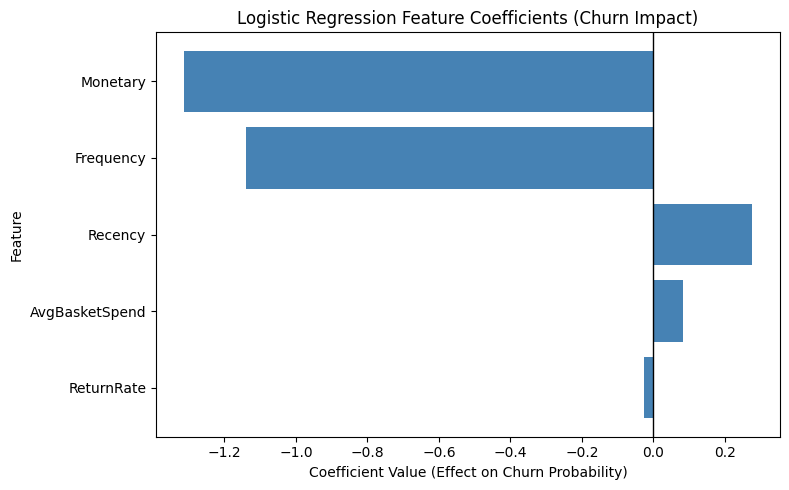

In [25]:
import pandas as pd
import numpy as np

# Get feature names after preprocessing
feature_names = logit.named_steps['pre'].transformers_[0][2]

# Extract coefficients (since we used a pipeline)
coefs = logit.named_steps['clf'].coef_.flatten()

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Importance(Abs)': np.abs(coefs)
}).sort_values(by='Importance(Abs)', ascending=False)

print("\nLogistic Regression Feature Importance (by absolute coefficient):\n")
print(importance_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='steelblue')
plt.axvline(0, color='black', linewidth=1)
plt.title("Logistic Regression Feature Coefficients (Churn Impact)")
plt.xlabel("Coefficient Value (Effect on Churn Probability)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()
plt.show()

**The strongest drivers of lower churn probability are Monetary value and Frequency, which both have large negative coefficients. Conversely, Recency is the only RFM feature that positively predicts churn, confirming that even a slight delay in purchase strongly increases the risk of customer loss.**

**Customer Churn Risk Tiers Assignment**

This Python code snippet applies a trained churn prediction model (presumably a logit model from a previous step) to a customer feature dataset (data[feature_cols]) to assign a risk level to every customer. It first uses the model's predict_proba method to generate the churn probability for each customer. It then defines a simple rule-based function, assign_tier, which categorizes these probabilities into three distinct Risk Tiers: "High" (probability $\ge 60\%$), "Medium" (probability $\ge 40\%$), or "Low" (probability $< 40\%$). The final output is an enriched DataFrame (scored) that includes the original RFM features, the true Churn_Label, the predicted Churn_Prob, and the newly created categorical Risk_Tier, allowing the business to prioritize retention efforts based on a quantitative measure of churn likelihood.

In [26]:
import numpy as np
import pandas as pd

# ---- thresholds (tune as needed) ----
T_HIGH = 0.60
T_MED  = 0.40

def assign_tier(p):
    if p >= T_HIGH:
        return "High"
    elif p >= T_MED:
        return "Medium"
    else:
        return "Low"

# 1) Predict churn probabilities
probs = logit.predict_proba(data[feature_cols])[:, 1]

# 2) Build scored frame
scored = data[['CustomerID','Churn_Label'] + feature_cols].copy()
scored['Churn_Prob'] = probs
scored['Risk_Tier']  = scored['Churn_Prob'].apply(assign_tier)

# Optional sanity checks
total_customers = scored['CustomerID'].nunique()
tier_counts = scored['Risk_Tier'].value_counts().to_dict()
print(f"Scored customers: {total_customers}")
print("Tier counts:", tier_counts)

Scored customers: 2769
Tier counts: {'Medium': 969, 'High': 968, 'Low': 832}


In [27]:
# Save to CSV
scored.to_csv("Total_customer.csv", index=False)
scored


,CustomerID,Churn_Label,Recency,Frequency,Monetary,AvgBasketSpend,ReturnRate,Churn_Prob,Risk_Tier
0,12347,0,39,63,1354.08,21.493333,0.000000,0.319194,Low
1,12348,0,158,4,327.00,81.750000,0.000000,0.770220,High
2,12352,0,171,21,240.66,11.460000,0.333333,0.706571,High
3,12353,1,113,4,89.00,22.250000,0.000000,0.717719,High
4,12354,1,141,54,1013.60,18.770370,0.000000,0.513946,Medium
...,...,...,...,...,...,...,...,...,...
2764,18273,0,5,2,153.00,76.500000,0.000000,0.623839,High
2765,18281,1,90,5,46.92,9.384000,0.000000,0.687468,High
2766,18282,0,31,8,100.21,12.526250,0.125000,0.598097,Medium
2767,18283,0,5,294,772.13,2.626293,0.000000,0.052797,Low


**Recency Vs. Churn Probability by Risk Tier**

<Figure size 1000x600 with 0 Axes>

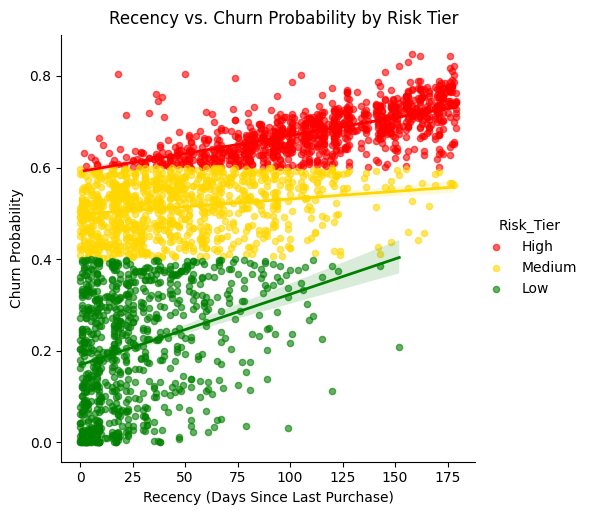

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataframe
df = pd.read_csv("Total_customer.csv")

# Define the custom color palette and order for the Risk_Tier
palette = {
    'High': 'red',
    'Medium': 'gold', # Using 'gold' for a better visual representation of 'yellow'
    'Low': 'green'
}
order = ['High', 'Medium', 'Low']

# Create the scatter plot with a linear regression line for each risk tier
plt.figure(figsize=(10, 6))
g = sns.lmplot(
    data=df,
    x='Recency',
    y='Churn_Prob',
    hue='Risk_Tier',
    palette=palette,
    hue_order=order,
    scatter_kws={'alpha': 0.6, 's': 20}, # Adjust scatter point properties
    line_kws={'lw': 2} # Adjust line properties
)

# Set the title and axis labels
g.fig.suptitle('Recency vs. Churn Probability by Risk Tier', y=1.02)
g.set_axis_labels("Recency (Days Since Last Purchase)", "Churn Probability")

# Save the plot
plt.savefig('recency_vs_churn_prob.png')

**List of Customers in Each Tier**

In [29]:
import pandas as pd

# Load the data
df = pd.read_csv('Total_customer.csv')

# Group by 'Risk_Tier' and get a list of 'CustomerID' for each group
risk_groups = df.groupby('Risk_Tier')['CustomerID'].apply(list)

# Extract lists for each risk tier, using .get() to safely handle missing tiers (though unlikely)
high_risk_customers = risk_groups.get('High', [])
medium_risk_customers = risk_groups.get('Medium', [])
low_risk_customers = risk_groups.get('Low', [])

# Print the results
print("High Risk Customers (Customer IDs):")
print(high_risk_customers)

print("\nMedium Risk Customers (Customer IDs):")
print(medium_risk_customers)

print("\nLow Risk Customers (Customer IDs):")
print(low_risk_customers)

High Risk Customers (Customer IDs):
[12348, 12352, 12353, 12355, 12356, 12358, 12372, 12383, 12393, 12394, 12413, 12414, 12426, 12434, 12447, 12450, 12493, 12506, 12507, 12510, 12516, 12539, 12541, 12545, 12547, 12548, 12564, 12573, 12580, 12582, 12585, 12589, 12596, 12601, 12604, 12609, 12622, 12639, 12654, 12679, 12690, 12691, 12694, 12701, 12724, 12728, 12732, 12733, 12754, 12755, 12763, 12770, 12778, 12781, 12790, 12792, 12798, 12802, 12808, 12811, 12814, 12818, 12821, 12823, 12826, 12831, 12837, 12845, 12849, 12854, 12857, 12863, 12864, 12871, 12888, 12897, 12902, 12915, 12917, 12924, 12937, 12939, 12968, 12974, 12976, 12977, 12980, 12981, 12982, 12987, 12990, 12997, 12999, 13029, 13035, 13038, 13046, 13052, 13055, 13058, 13059, 13060, 13062, 13070, 13072, 13080, 13092, 13093, 13101, 13104, 13106, 13107, 13120, 13121, 13126, 13130, 13131, 13132, 13147, 13151, 13168, 13169, 13185, 13194, 13196, 13207, 13216, 13218, 13220, 13221, 13223, 13225, 13227, 13229, 13238, 13239, 13253, 1325

**The majority of the current customer base is at high or medium risk of churning (69.8% of customers), indicating that retention efforts need to be aggressively prioritized and targeted toward nearly two-thirds of all users.**

**Summary “dashboard” table (counts, churn rate, avg RFM/features)**

**Summarizing Customer Behavior by Churn Risk Tier**

In [30]:
# Aggregations per tier
agg_map = {
    'CustomerID': 'nunique',
    'Churn_Prob':  'mean',
    'Churn_Label': 'mean',          # becomes churn RATE if 0/1
    'Recency':     'mean',
    'Frequency':   'mean',
    'Monetary':    'mean',
    'AvgBasketSpend': 'mean',
    'ReturnRate':  'mean'
}

summary = (scored
           .groupby('Risk_Tier', as_index=False)
           .agg(agg_map)
           .rename(columns={
               'CustomerID':'Customers',
               'Churn_Prob':'Avg_Prob',
               'Churn_Label':'Actual_ChurnRate'
           }))

# Add % of portfolio
summary['Portfolio_%'] = (summary['Customers'] / total_customers * 100).round(1)

# Order tiers
tier_order = ['High','Medium','Low']
summary = summary.set_index('Risk_Tier').reindex(tier_order).reset_index()

# Round for display
cols_to_round = ['Avg_Prob','Actual_ChurnRate','Recency','Frequency','Monetary','AvgBasketSpend','ReturnRate']
summary[cols_to_round] = summary[cols_to_round].round(3)

print("\nChurn Risk Tier Summary:\n")
print(summary)


Churn Risk Tier Summary:

  Risk_Tier  Customers  Avg_Prob  Actual_ChurnRate  Recency  Frequency  \
0      High        968     0.681             0.582  113.780     13.504   
1    Medium        969     0.514             0.369   47.953     32.301   
2       Low        832     0.211             0.141   27.035    133.429   

   Monetary  AvgBasketSpend  ReturnRate  Portfolio_%  
0   227.532          26.634       0.049         35.0  
1   523.030          20.461       0.023         35.0  
2  2316.738          21.072       0.025         30.0  


High-Risk Customers (35% of the base) have an $\mathbf{58.2\%}$ actual churn rate and are defined by high Recency (114 days) and the lowest Frequency and Monetary values, making them prime candidates for immediate, cost-effective re-engagement campaigns.Low-Risk Customers ($\mathbf{30\%}$ of the base) are the most valuable, possessing the highest Monetary (2,317 pounds) and Frequency (133 orders), and the lowest actual churn rate ($\mathbf{14.1\%}$); efforts here should focus on maximizing lifetime value and loyalty rewards.Medium-Risk Customers ($\mathbf{35\%}$ of the base) are a complex intermediate group with a $\mathbf{36.9\%}$ actual churn rate and high average Monetary value (523 pounds); they require intervention to prevent them from slipping into the High-Risk category.

### Visualization

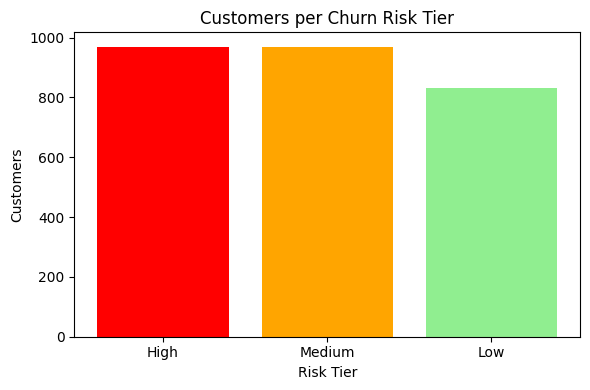

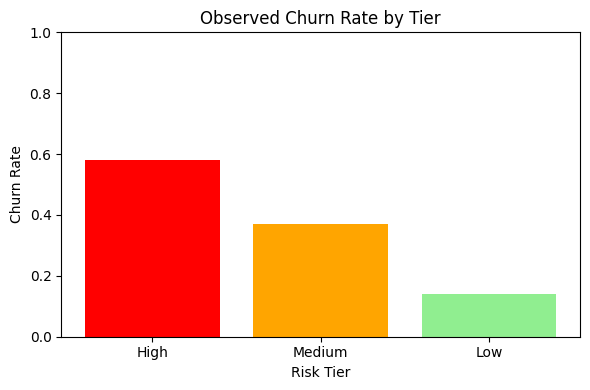

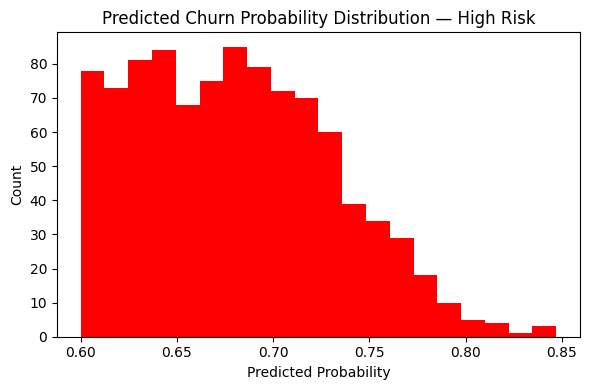

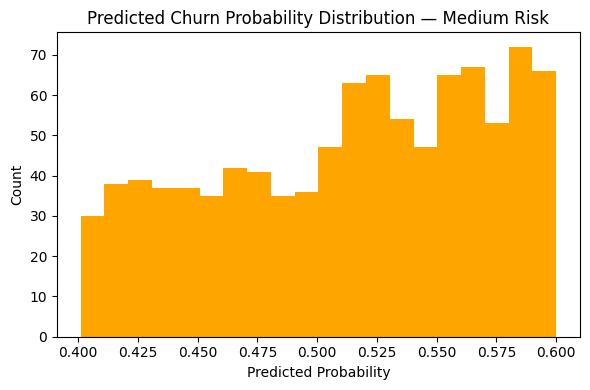

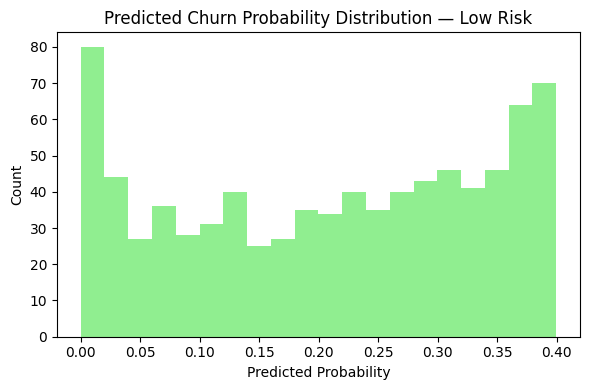

In [31]:
import matplotlib.pyplot as plt
tier_colors = {'High': 'red', 'Medium': 'orange', 'Low': 'lightgreen'}

# --- a) Customers per tier ---
counts = summary.set_index('Risk_Tier')['Customers']

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values, color=[tier_colors[tier] for tier in counts.index])
plt.title("Customers per Churn Risk Tier")
plt.ylabel("Customers"); plt.xlabel("Risk Tier")
plt.tight_layout(); plt.show()

# --- b) Actual churn rate per tier (if labels available) ---
rates = summary.set_index('Risk_Tier')['Actual_ChurnRate']

plt.figure(figsize=(6,4))
plt.bar(rates.index, rates.values, color=[tier_colors[tier] for tier in rates.index])
plt.title("Observed Churn Rate by Tier")
plt.ylabel("Churn Rate"); plt.xlabel("Risk Tier")
plt.ylim(0, 1)
plt.tight_layout(); plt.show()

# --- c) Distribution of predicted probabilities by tier (histograms) ---
for tier in tier_order:
    plt.figure(figsize=(6,4))
    s = scored.loc[scored['Risk_Tier']==tier, 'Churn_Prob']
    plt.hist(s.values, bins=20, color=tier_colors[tier])
    plt.title(f"Predicted Churn Probability Distribution — {tier} Risk")
    plt.xlabel("Predicted Probability"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


**Customers per Churn Risk Tier (Bar Chart)
Takeaway: The customer base is currently highly concentrated in the at-risk segments, with the High and Medium tiers each containing approximately 35% of the total customer count, requiring broad retention strategies.**

**Observed Churn Rate by Tier (Bar Chart)Takeaway: The model is effectively segregating risk, as the Actual Churn Rate decreases sharply from $\mathbf{58\%}$ in the High Tier to $\mathbf{14\%}$ in the Low Tier, validating the model's predictive power for segmentation.**

**Predicted Churn Probability Distribution — High Risk (Histogram)Takeaway: Probabilities for the High Risk segment (defined as $P \ge 0.60$) are mostly clustered in the narrow range of $60\%$ to $75\%$, suggesting a relatively uniform group that can be targeted with a single, high-urgency campaign.**

**Predicted Churn Probability Distribution — Medium Risk (Histogram)Takeaway: The Medium Risk segment (defined as $0.40 \le P < 0.60$) shows a broad and scattered distribution, indicating this group is highly diverse and would benefit most from sub-segmentation and varied marketing offers.**

**Predicted Churn Probability Distribution — Low Risk (Histogram)Takeaway: The Low Risk segment ($P < 0.40$) is highly polarized, with large groups clustered at both very low probabilities (near $0\%$) and near the $40\%$ threshold, suggesting two distinct sub-groups where resource allocation should be prioritized for the group closer to $40\%$.**

In [32]:
summary.to_csv("churn_risk_tier_dashboard.csv", index=False)
scored.to_csv("churn_scored_customers_with_tiers.csv", index=False)
print("Saved: churn_risk_tier_dashboard.csv, churn_scored_customers_with_tiers.csv")


Saved: churn_risk_tier_dashboard.csv, churn_scored_customers_with_tiers.csv


### So What steps can be taken now?

🟥 1. High-Risk Customers (p ≥ 0.70)
Profile: High probability of churn. Often show high Recency (inactive recently) and low Frequency/Monetary value

May have negative experiences (e.g., returns, poor service)

🎯 Objective: Retain or reactivate these customers immediately.

🔧 Actions: Action Type	Description
- Win-back Campaigns: Send personalized “We miss you” messages or reactivation offers (e.g., 30% off next purchase, “come back” deals).
- Feedback Loop: Ask for feedback through short surveys to learn why they disengaged.
- Urgency-based Offers: Limited-time discounts or loyalty bonus points to create FOMO.
- Service Recovery: Identify customers with high ReturnRate → offer apology, refund, or special support.
- Proactive Outreach: Customer service or CRM team directly contacts top-value churners.

🟧 2. Medium-Risk Customers (0.40 ≤ p < 0.70)
Profile: Moderate engagement but inconsistent. May be influenced by competitors or seasonal inactivity. Still responsive to engagement

🎯 Objective: Prevent churn through engagement and loyalty reinforcement.

🔧 Actions: Action Type	Description
- Loyalty & Reward Programs: Offer tiered benefits or reward points for consistent purchases.
- Personalized Recommendations:	Use purchase history to suggest complementary products or meals (if restaurant context).
- Email & Push Nurturing: Send curated “Top Picks” or “Special Offers Just for You.”
- Gamification: Introduce points, badges, or challenges (“Spend $50 more to unlock rewards”).
- Social Engagement: Encourage reviews, referrals, or social sharing to increase brand touchpoints.

🟩 3. Low-Risk Customers (p < 0.40)
Profile: Loyal and engaged. High Frequency, High Monetary, Low Recency. Often promoters or brand advocates

🎯 Objective: Retain and nurture these customers; convert them into brand ambassadors.

🔧 Actions: Action Type	Description
- VIP / Exclusive Perks: Early access to new products, members-only menus, or invites to special events.
- Referral Programs: Incentivize loyal customers to refer friends (“Get $10 credit for every friend”).
- Upselling & Cross-selling: Suggest premium products, combos, or upgrades.
- Customer Appreciation: Send thank-you messages, anniversary gifts, or free loyalty vouchers.
- Predictive Maintenance: Monitor if these customers begin showing early signs of churn and act preemptively.

### Retension Action Simulation

**Churn Intervention Cost and Benefit Configuration**

This Python code snippet establishes a configuration framework using dictionaries to define the costs, expected effectiveness, and financial value associated with various customer churn intervention strategies. It defines five potential ACTIONS (ranging from simple email to expensive call-and-coupon bundles) along with their corresponding fixed contact costs and variable offer costs. It then models the effectiveness of these interventions by defining expected REDEMPTION rates and UPLIFT (absolute retention lift) percentages, both segmented by the customer's Churn Risk Tier ("High," "Medium," "Low"). Finally, a simplified MARGIN value is assigned to each risk tier, serving as a proxy for the expected gross profit generated by a successfully retained customer, setting the stage for calculating the ROI of different marketing campaigns per segment.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Actions we can take (channel + incentive bundle) ----
ACTIONS = {
    "none":  {"contact_cost": 0.00, "offer_cost": 0.00},
    "email": {"contact_cost": 0.01, "offer_cost": 0.00},
    "sms":   {"contact_cost": 0.05, "offer_cost": 0.00},
    "sms+coupon": {"contact_cost": 0.05, "offer_cost": 6.00},
    "call+coupon": {"contact_cost": 2.00, "offer_cost": 6.00},  # consider for high-value only
}

# ---- Redemption rate by tier (probability that offer is redeemed if one is present) ----
REDEMPTION = {
    "High":   0.30,
    "Medium": 0.20,
    "Low":    0.10,
}

# ---- Uplift (absolute retention lift) by tier & action ----
# Think of this as: among similar customers, taking this action increases retention by X percentage points.
UPLIFT = {
    "High":   {"none":0.00, "email":0.05, "sms":0.10, "sms+coupon":0.20, "call+coupon":0.25},
    "Medium": {"none":0.00, "email":0.05, "sms":0.10, "sms+coupon":0.10, "call+coupon":0.12},
    "Low":    {"none":0.00, "email":0.02, "sms":0.03, "sms+coupon":0.02, "call+coupon":0.02},
}

# ---- Margin (gross margin realizable over your horizon) by tier ----
# You can swap this to a per-customer proxy (see note below).
MARGIN = {"High": 50.0, "Medium": 70.0, "Low": 120.0}


**Calculating Customer Retention Campaign ROI**

This Python code snippet performs a crucial Expected Value (EV) analysis to determine the optimal marketing intervention for each customer segment based on profitability. It creates a comprehensive dataset by cross-merging every customer with every possible action (e.g., 'email', 'call+coupon'). For each customer-action pair, it calculates the Expected Cost by summing the fixed contact cost and the expected offer cost (offer cost $\times$ redemption probability). It then calculates the Incremental Gross Margin using a profit-per-customer proxy (Margin), the predicted $\mathbf{p(churn)}$, and the action's estimated Uplift (absolute increase in retention). The final metric, Expected Value (EV), is derived by subtracting the Expected Cost from the Incremental Gross Margin, quantifying the net value generated by applying a specific retention strategy to a customer in a given risk tier.

In [34]:
# Safety: ensure we have churn probs and tiers (reuse your prior outputs)
req_cols = {"CustomerID","Churn_Prob","Risk_Tier"}
missing = req_cols - set(scored.columns)
if missing:
    raise ValueError(f"scored is missing required columns: {missing}")

# Expand: one row per (customer, action)
act_df = pd.DataFrame(
    [(a, ACTIONS[a]["contact_cost"], ACTIONS[a]["offer_cost"]) for a in ACTIONS],
    columns=["Action","ContactCost","OfferCost"]
)

expanded = scored.merge(act_df, how="cross")

# Expected cost per row (offer cost is expected only when redeemed)
expanded["Redemption"] = expanded["Risk_Tier"].map(REDEMPTION)
expanded["ExpectedCost"] = expanded["ContactCost"] + expanded["Redemption"] * expanded["OfferCost"]

# Margin source: per-customer Margin_Est (if exists) else tier margin
if "Margin_Est" in expanded.columns:
    expanded["MarginUsed"] = expanded["Margin_Est"].astype(float)
else:
    expanded["MarginUsed"] = expanded["Risk_Tier"].map(MARGIN)

# Uplift (absolute lift) looked up by (tier, action)
def lookup_uplift(row):
    return UPLIFT[row["Risk_Tier"]].get(row["Action"], 0.0)

expanded["Uplift"] = expanded.apply(lookup_uplift, axis=1)

# We only retain customers who would have churned; approximate with p(churn) * uplift
# Incremental gross margin = margin * p(churn) * uplift
expanded["IncGrossMargin"] = expanded["MarginUsed"] * expanded["Churn_Prob"] * expanded["Uplift"]

# Net Expected Value per contacted customer for that action
expanded["EV"] = expanded["IncGrossMargin"] - expanded["ExpectedCost"]

**Total Expected Value**

In [35]:
# --- 1. Load your scored customer data ---
df = pd.read_csv("churn_scored_customers_with_tiers.csv")

# --- 2. Compute probability of staying ---
df['Prob_Stay'] = 1 - df['Churn_Prob']

# --- 3. Expected Value per Customer ---
df['Expected_Value'] = df['Prob_Stay'] * df['Monetary']

# --- 4. Total Expected Value across all customers ---
total_expected_value = df['Expected_Value'].sum()

print(f"💰 Total Expected Value (Revenue Adjusted for Retention): £{total_expected_value:,.2f}")


💰 Total Expected Value (Revenue Adjusted for Retention): £2,025,670.61


**Optimal Churn Policy Selection and Financial Summary**

This code snippet finalizes the churn intervention analysis by establishing the optimal marketing policy for every customer and then generating comprehensive financial summaries. First, it determines the best action for each customer by selecting the one with the maximum Expected Value (EV) from the expanded dataset. It then generates three key summary tables: a Portfolio Summary providing the total expected cost, incremental gross margin, and net EV across the entire customer base; a By-Tier Summary breaking down these financial metrics and average churn probability for each "High," "Medium," and "Low" risk segment; and a By-Action Summary totaling the financial outcomes for each specific marketing strategy chosen (e.g., 'sms+coupon'). This process translates the complex probabilistic modeling into clear, actionable financial figures used to justify and budget the retention strategy.

In [36]:
# ----------------------------
# Pick best action per customer
# ----------------------------
# Robust way: sort by EV and take the last (max) row per customer
policy = (expanded.sort_values(["CustomerID", "EV"])
          .groupby("CustomerID", as_index=False)
          .tail(1)
          .reset_index(drop=True))

# Keep the key columns tidy
policy = policy[[
    "CustomerID", "Risk_Tier", "Churn_Prob", "Action",
    "Uplift", "ExpectedCost", "IncGrossMargin", "EV", "MarginUsed"
]]

# ----------------------------
# Portfolio summary (single row)
# ----------------------------
portfolio = pd.DataFrame([{
    "Customers": policy["CustomerID"].nunique(),
    "Total_Expected_Cost": policy["ExpectedCost"].sum(),
    "Total_Inc_GrossMargin": policy["IncGrossMargin"].sum(),
    "Total_EV": policy["EV"].sum(),
    "Avg_EV_per_Customer": policy["EV"].mean()
}])

# ----------------------------
# By-tier summary
# ----------------------------
by_tier = (policy.groupby("Risk_Tier", as_index=False)
           .agg(
               Customers=("CustomerID", "nunique"),
               Mean_Prob=("Churn_Prob", "mean"),
               Total_Cost=("ExpectedCost", "sum"),
               Total_IncGM=("IncGrossMargin", "sum"),
               Total_EV=("EV", "sum"),
               Avg_EV=("EV", "mean")
           ))

# ----------------------------
# By-action summary
# ----------------------------
by_action = (policy.groupby("Action", as_index=False)
             .agg(
                 Customers=("CustomerID", "nunique"),
                 Total_Cost=("ExpectedCost", "sum"),
                 Total_IncGM=("IncGrossMargin", "sum"),
                 Total_EV=("EV", "sum"),
                 Avg_EV=("EV", "mean")
             ))

print("\n=== Portfolio Summary ===")
print(portfolio.round(2))

print("\n=== By Tier ===")
print(by_tier.round(2))

print("\n=== By Action ===")
print(by_action.round(2))

# Save the 'by_tier' DataFrame to a CSV file named 'risk_tier.csv'
by_tier.to_csv("risk_tier.csv", index=False)
by_action.to_csv("risk_action.csv", index=False)


=== Portfolio Summary ===
   Customers  Total_Expected_Cost  Total_Inc_GrossMargin  Total_EV  \
0       2769              1928.65               10757.48   8828.83   

   Avg_EV_per_Customer  
0                 3.19  

=== By Tier ===
  Risk_Tier  Customers  Mean_Prob  Total_Cost  Total_IncGM  Total_EV  Avg_EV
0      High        968       0.68     1843.45      6642.41   4798.96    4.96
1       Low        832       0.21       36.75       629.14    592.39    0.71
2    Medium        969       0.51       48.45      3485.93   3437.48    3.55

=== By Action ===
        Action  Customers  Total_Cost  Total_IncGM  Total_EV  Avg_EV
0  call+coupon         27      102.60       270.88    168.28    6.23
1        email         70        0.70         3.14      2.44    0.03
2         none         41        0.00         0.00      0.00    0.00
3          sms       1690       84.50      4111.93   4027.43    2.38
4   sms+coupon        941     1740.85      6371.54   4630.69    4.92


**Overall Profitability:** The optimal churn prevention strategy yields a positive Total Expected Value (EV) of 8,828.83 pounds and an average net gain of 3.19 pounds per contacted customer, proving the program is financially viable.

**Strategic Focus (High Tier):** The High-Risk Tier is the most profitable segment to target, generating the highest Total EV 4,798.96 pounds and Avg EV 4.96 pounds per customer, despite having the highest associated costs.

**Optimal Action:** The sms+coupon action is the most crucial, driving the majority of the profit with a Total EV of 4,630.69 pounds and an excellent Avg EV of 4.92 pounds, while the low-cost sms action is best for broad reach, generating 4,027.43 pounds from 1,690 customers.

/tmp/ipython-input-3047930996.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3047930996.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("bar_EV_by_action_percent.png", dpi=200, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


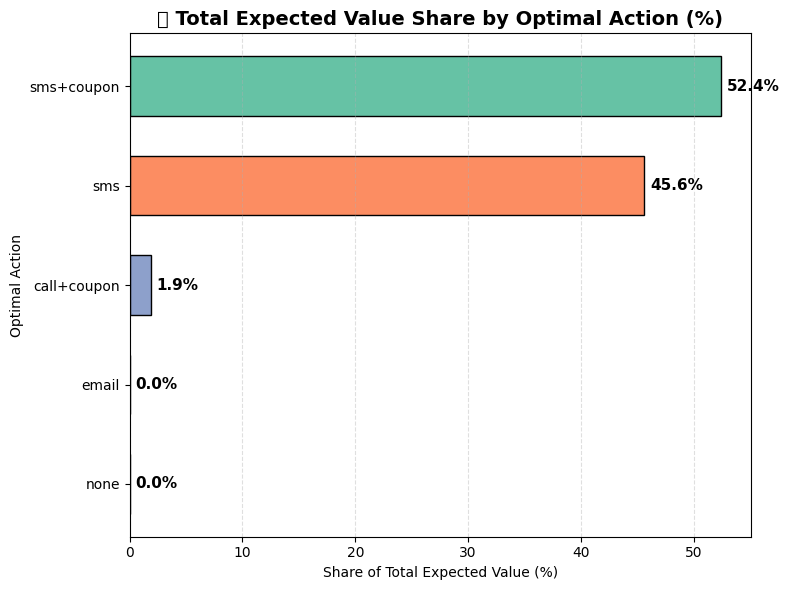

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# --- Sort data by Total_EV for consistency ---
by_action_sorted = by_action.sort_values("Total_EV", ascending=False).reset_index(drop=True)

# --- Extract labels and values ---
actions = by_action_sorted["Action"].astype(str)
values = by_action_sorted["Total_EV"].values

# --- Calculate percentage share for labels ---
percentages = (values / values.sum()) * 100

# --- Define colors ---
colors = plt.get_cmap("Set2").colors[:len(actions)]

# --- Create Bar Chart ---
plt.figure(figsize=(8, 6))
bars = plt.barh(actions, percentages, color=colors, edgecolor="black", height=0.6)

# Add percentage labels
for bar, pct in zip(bars, percentages):
    plt.text(pct + 0.5, bar.get_y() + bar.get_height()/2,
             f"{pct:.1f}%", va='center', fontsize=11, weight='bold')

plt.title("📊 Total Expected Value Share by Optimal Action (%)", fontsize=14, weight='bold')
plt.xlabel("Share of Total Expected Value (%)")
plt.ylabel("Optimal Action")
plt.gca().invert_yaxis()  # Highest % on top
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig("bar_EV_by_action_percent.png", dpi=200, bbox_inches='tight')
plt.show()


#### Simple visuals (one figure per chart)

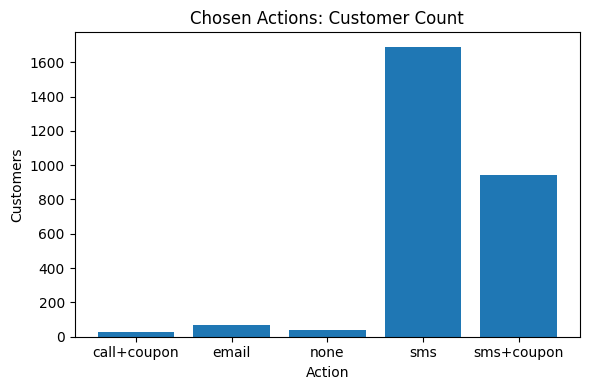

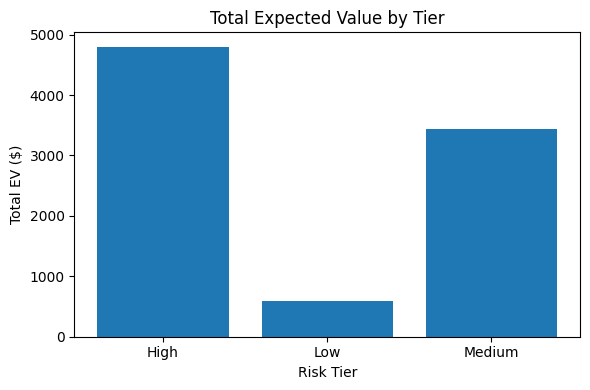

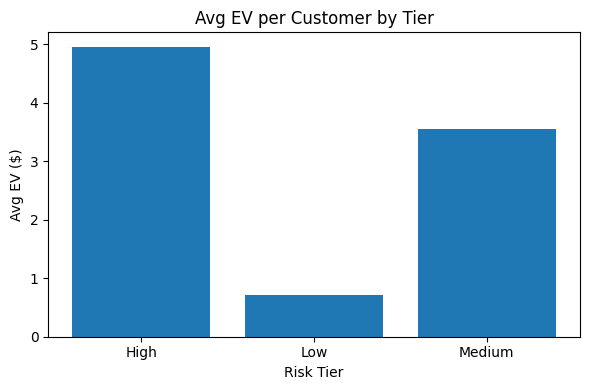

In [38]:
# a) Customers by chosen action
plt.figure(figsize=(6,4))
plt.bar(by_action["Action"], by_action["Customers"])
plt.title("Chosen Actions: Customer Count")
plt.xlabel("Action"); plt.ylabel("Customers")
plt.tight_layout(); plt.show()

# b) Total Expected Value (EV) by tier
plt.figure(figsize=(6,4))
plt.bar(by_tier["Risk_Tier"], by_tier["Total_EV"])
plt.title("Total Expected Value by Tier")
plt.xlabel("Risk Tier"); plt.ylabel("Total EV ($)")
plt.tight_layout(); plt.show()

# c) Average EV per customer by tier
plt.figure(figsize=(6,4))
plt.bar(by_tier["Risk_Tier"], by_tier["Avg_EV"])
plt.title("Avg EV per Customer by Tier")
plt.xlabel("Risk Tier"); plt.ylabel("Avg EV ($)")
plt.tight_layout(); plt.show()


**Total Expected Value by TierTakeaway: The High Risk Tier generates the highest Total Expected Value (EV) (nearly4,800 pounds), followed closely by the Medium Risk Tier, proving these two at-risk segments are the most financially rewarding targets for retention spending.**

**Avg EV per Customer by TierTakeaway: Targeting High Risk customers is the most efficient strategy, as they yield the highest Average EV per customer (~5.00 pounds), while targeting Low Risk customers provides the lowest return (less than 1.00 pounds per customer).**

**Chosen Actions: Customer CountTakeaway: The optimal policy heavily favors SMS-based campaigns, with sms (low-cost, broad reach) being chosen for the largest number of customers ($\sim 1,700$) and sms+coupon (high incentive) being chosen for the second-largest group ($\sim 950$).**

**Heat Map: Visualizing the Optimal Retention Policy**

This Python code snippet visualizes the profitability of every potential churn intervention across all customer risk segments using a heatmap. It takes the detailed, cross-merged customer data (expanded), which contains the calculated Expected Value (EV) for every customer paired with every possible marketing action. It aggregates this data by calculating the mean EV for each unique combination of Risk_Tier ("High," "Medium," "Low") and Action (e.g., 'sms', 'call+coupon'). Finally, it uses seaborn to render this aggregated data as a Policy Reward Matrix heatmap, where the color intensity and annotations show the average net expected profit (EV) generated by applying a specific retention strategy to a customer in a specific risk tier. This visually identifies the most financially rewarding action for each segment.

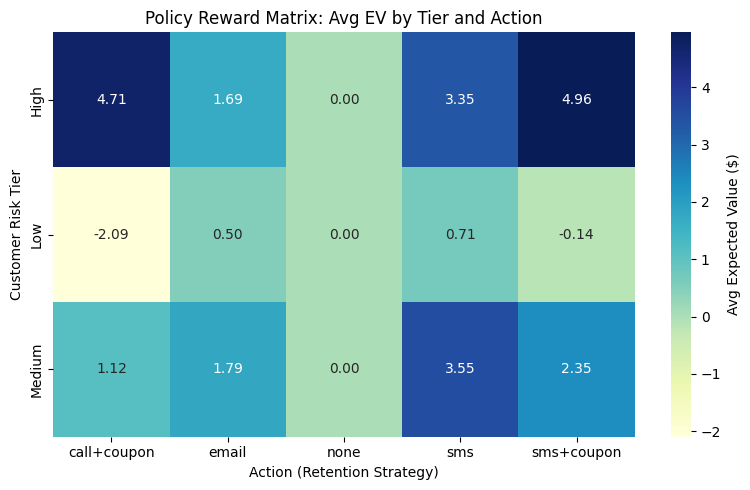

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your expanded or policy DataFrame exists
# (Use expanded if you want all action combos; policy if only the chosen ones)
# Example: use `expanded` to visualize all (tier, action) EV values
df_heat = expanded.copy()

# Compute mean EV per (tier, action)
reward_matrix = (
    df_heat.groupby(["Risk_Tier", "Action"])["EV"]
    .mean()
    .reset_index()
    .pivot(index="Risk_Tier", columns="Action", values="EV")
)

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(reward_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Expected Value ($)'})
plt.title("Policy Reward Matrix: Avg EV by Tier and Action")
plt.xlabel("Action (Retention Strategy)")
plt.ylabel("Customer Risk Tier")
plt.tight_layout()
plt.show()


**High-Risk Customers must be retained using the sms+coupon strategy, as it yields the highest average return at 4.96 pounds EV per customer.**

**Medium-Risk Customers are best handled with a low-cost sms campaign, offering the highest efficiency at 3.55 pounds EV per customer.**

**Low-Risk Customers should not be targeted with coupons or calls (negative EV), but simple sms (0.71 pounds EV) or email (0.50 pounds EV) campaigns offer a marginal positive return.**

### Agentic AI Policy Engine

Agentic AI policy engine operates in a unique way. It's a simulation that likely runs over many time steps, **making decisions for a larger population** than just the **initially "at-risk" group (2,832 customers)**. The number **21,445 (4289*5)** represents the **total number of actions** taken across all simulation steps, not a one-time assignment to a fixed set of customers. The policy engine could be testing actions on all 4,289 customers, or a rotating subset of them, to learn the optimal strategy.

#### Load and merge data

In [40]:
import pandas as pd
import numpy as np

# Load files
rfm = pd.read_csv("rfm.csv")
risk_tier = pd.read_csv("churn_risk_tier_dashboard.csv")
risk_category = pd.read_csv("churn_scored_customers_with_tiers.csv")
risk_action = pd.read_csv("risk_action.csv")
retail = pd.read_csv("online_retail_cleaned.csv")

rfm.columns

Index(['CustomerID', 'LastPurchaseDate', 'Recency', 'Frequency', 'Monetary',
       'Churn_Label'],
      dtype='object')

In [41]:
risk_tier.columns

Index(['Risk_Tier', 'Customers', 'Avg_Prob', 'Actual_ChurnRate', 'Recency',
       'Frequency', 'Monetary', 'AvgBasketSpend', 'ReturnRate', 'Portfolio_%'],
      dtype='object')

In [42]:
risk_category.columns

Index(['CustomerID', 'Churn_Label', 'Recency', 'Frequency', 'Monetary',
       'AvgBasketSpend', 'ReturnRate', 'Churn_Prob', 'Risk_Tier'],
      dtype='object')

In [43]:
risk_action.columns

Index(['Action', 'Customers', 'Total_Cost', 'Total_IncGM', 'Total_EV',
       'Avg_EV'],
      dtype='object')

In [44]:
retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'is_return', 'is_cancelled',
       'TotalAmount', 'InvoiceYear', 'InvoiceMonth', 'InvoiceDay',
       'InvoiceWeek', 'InvoiceWeekday', 'InvoiceHour', 'IsWeekend',
       'NetAmount', 'SalesAmount', 'BasketUniqueItems_x', 'BasketLineCount_x',
       'BasketTotalQty_x', 'BasketSalesAmount_x', 'CustProductDiversity_x',
       'CustInvoiceCount_x', 'CustAvgBasketUniqueItems_x', 'CustReturnRate_x',
       'CustAvgOrderValue_x', 'CustTotalSales_x', 'IsUK',
       'BasketUniqueItems_y', 'BasketLineCount_y', 'BasketTotalQty_y',
       'BasketSalesAmount_y', 'CustProductDiversity_y', 'CustInvoiceCount_y',
       'CustAvgBasketUniqueItems_y', 'CustReturnRate_y', 'CustAvgOrderValue_y',
       'CustTotalSales_y'],
      dtype='object')

**Data Consolidation and Action Planning Expansion**

This comprehensive Python script consolidates information from five separate CSV files, cleans their column names to ensure consistency, and prepares a unified dataset for a final, detailed retention strategy analysis. It first performs a series of merges, joining the core RFM data with risk scoring features (churn_prob, risk_tier) and the customer's country. It then processes the risk_action summary to create an Action Catalog, calculating the expected cost and value metrics per customer for each marketing action. Crucially, the script then performs a final cross-join between the single-row customer profile table and the Action Catalog, creating an expanded DataFrame where every customer is paired with every potential retention action. This final structure, free of customer ID duplicates, enables analysts to quickly compare the estimated outcome of any given action for any customer, effectively operationalizing the churn model's output.

In [45]:
import pandas as pd
import numpy as np

# -----------------------------
# 1) Load CSVs
# -----------------------------
rfm = pd.read_csv("rfm.csv")
risk_tier = pd.read_csv("churn_risk_tier_dashboard.csv")
risk_category = pd.read_csv("churn_scored_customers_with_tiers.csv")
risk_action = pd.read_csv("risk_action.csv")
retail = pd.read_csv("online_retail_cleaned.csv")

# -----------------------------
# 2) Normalize column names
# -----------------------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.replace(" ", "_", regex=False)
                  .str.replace("-", "_", regex=False)
                  .str.lower()
    )
    return df

rfm = clean_cols(rfm)
risk_tier = clean_cols(risk_tier)
risk_category = clean_cols(risk_category)
risk_action = clean_cols(risk_action)
retail = clean_cols(retail)

# Print column names after cleaning for debugging
print("rfm columns:", rfm.columns.tolist())
print("risk_tier columns:", risk_tier.columns.tolist())
print("risk_category columns:", risk_category.columns.tolist())
print("risk_action columns:", risk_action.columns.tolist())
print("retail columns:", retail.columns.tolist())


id_col = "customerid" # Corrected based on potential lowercase cleaning

# Make sure ID exists after cleaning
for name, df_cleaned in [("rfm", rfm), ("risk_category", risk_category), ("retail", retail)]:
    if id_col not in df_cleaned.columns:
        raise KeyError(f"{name} is missing '{id_col}' after column cleaning.")

# -----------------------------
# 3) Customer-level merge
#    rfm ⟵ risk_category (adds Risk_Tier, Churn_Prob, etc.)
# -----------------------------
keep_cols_rc = [c for c in [
    id_col, "churn_label", "recency", "frequency", "monetary",
    "avgbasketspend", "returnrate", "churn_prob", "risk_tier"
] if c in risk_category.columns]

cust = pd.merge(
    rfm,
    risk_category[keep_cols_rc],
    on=id_col, how="left", suffixes=("", "_rc")
)

# Add Country from retail
if "country" in retail.columns:
    country_map = retail[[id_col, "country"]].drop_duplicates()
    cust = pd.merge(cust, country_map, on=id_col, how="left")

# Enrich with tier-level aggregates (join on Risk_Tier)
# Not required for keys; purely informative features
tier_cols = [c for c in [
    "risk_tier", "customers", "avg_prob", "actual_churnrate",
    "recency", "frequency", "monetary", "avgbasketspend",
    "returnrate", "portfolio_%"
] if c in risk_tier.columns]

if "risk_tier" in cust.columns and "risk_tier" in risk_tier.columns and tier_cols:
    cust = pd.merge(
        cust, risk_tier[tier_cols],
        on="risk_tier", how="left", suffixes=("", "_tier")
    )

# -----------------------------
# 4) Build action catalog from risk_action totals
# -----------------------------
ra = risk_action.copy()
# Expect: ['Action','Customers','Total_Cost','Total_IncGM','Total_EV','Avg_EV']
if "action" not in ra.columns:
    raise KeyError("risk_action must contain 'Action'.")

# Compute per-customer priors (guard division by zero)
if {"customers","total_cost","total_incgm","total_ev"}.issubset(ra.columns):
    denom = ra["customers"].replace({0: np.nan})
    ra["cost_per_customer"]  = ra["total_cost"]  / denom
    ra["incgm_per_customer"] = ra["total_incgm"] / denom
    ra["ev_per_customer"]    = (ra["avg_ev"] if "avg_ev" in ra.columns
                                else ra["total_ev"] / denom)
else:
    # If only Avg_EV exists
    ra["cost_per_customer"]  = np.nan
    ra["incgm_per_customer"] = np.nan
    ra["ev_per_customer"]    = ra["avg_ev"] if "avg_ev" in ra.columns else np.nan

action_catalog = (
    ra[["action", "cost_per_customer", "incgm_per_customer", "ev_per_customer"]]
      .drop_duplicates(subset=["action"])
      .reset_index(drop=True)
)

# -----------------------------
# 5) De-duplicate customers (1 row per Customer_ID)
#    Prefer the most recent LastPurchaseDate if present
# -----------------------------
if "lastpurchasedate" in cust.columns:
    # Coerce to datetime for reliable sorting
    cust["_lpd_"] = pd.to_datetime(cust["lastpurchasedate"], errors="coerce")
    cust = (cust.sort_values([id_col, "_lpd_"])
                .drop_duplicates(subset=[id_col], keep="last")
                .drop(columns=["_lpd_"]))
else:
    cust = cust.drop_duplicates(subset=[id_col], keep="last")

print(f"Customers table: {cust.shape}  | unique customers: {cust[id_col].nunique()}")

# -----------------------------
# 6) Cross-join: customers × actions
# -----------------------------
cust["__k__"] = 1
action_catalog["__k__"] = 1
cx = (cust.merge(action_catalog, on="__k__", how="inner")
          .drop(columns="__k__")
          .reset_index(drop=True))

print(f"✅ Actions catalog: {action_catalog.shape}  | actions: {action_catalog['action'].tolist()}")
print(f"✅ Expanded (customers × actions): {cx.shape}")

# Optional peek
# display(cust.head(3))
# display(action_catalog)
# display(cx.head(5))

rfm columns: ['customerid', 'lastpurchasedate', 'recency', 'frequency', 'monetary', 'churn_label']
risk_tier columns: ['risk_tier', 'customers', 'avg_prob', 'actual_churnrate', 'recency', 'frequency', 'monetary', 'avgbasketspend', 'returnrate', 'portfolio_%']
risk_category columns: ['customerid', 'churn_label', 'recency', 'frequency', 'monetary', 'avgbasketspend', 'returnrate', 'churn_prob', 'risk_tier']
risk_action columns: ['action', 'customers', 'total_cost', 'total_incgm', 'total_ev', 'avg_ev']
retail columns: ['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country', 'is_return', 'is_cancelled', 'totalamount', 'invoiceyear', 'invoicemonth', 'invoiceday', 'invoiceweek', 'invoiceweekday', 'invoicehour', 'isweekend', 'netamount', 'salesamount', 'basketuniqueitems_x', 'basketlinecount_x', 'baskettotalqty_x', 'basketsalesamount_x', 'custproductdiversity_x', 'custinvoicecount_x', 'custavgbasketuniqueitems_x', 'custreturnrate_x', 'custavgor

**Contextual Churn Policy Optimization (LinUCB)**

This script implements a Contextual Bandit algorithm, LinUCB, to dynamically learn and recommend the single best retention action for every customer, maximizing the overall expected reward. It starts by engineering a reward signal based on the predicted Expected Value (ev_per_customer), weighted by the customer's churn probability and monetary potential. It then prepares a rich context vector ($x$) for each customer using their RFM features, risk tier, and country. The core of the code iterates through each unique customer: it calculates a Upper Confidence Bound (UCB) score for every possible action based on past performance, chooses the action with the highest UCB score, observes the engineered reward, and immediately uses that information to update the model's knowledge for the chosen action. This process creates a personalized policy that balances exploration (trying uncertain actions) and exploitation (choosing the best-known action), culminating in summary tables and visualizations of the recommended action mix.

✅ Done
  Chosen_Action  Average_Reward  Customers
0   call+coupon        3.276839       2818
1    sms+coupon        1.060780        428
2           sms        0.010351        343
3         email        0.000181        366
4          none        0.000000        357
Chosen_Action  call+coupon  email  none  sms  sms+coupon
Risk_Tier                                               
High                   958      1     2    1           6
Low                    688      7    11    8         118
Medium                 914      1     1    0          53
nan                    258    357   343  334         251
✅ Saved: contextual_policy_recommendations.csv, contextual_policy_summary.csv, contextual_policy_tier_action_mix.csv


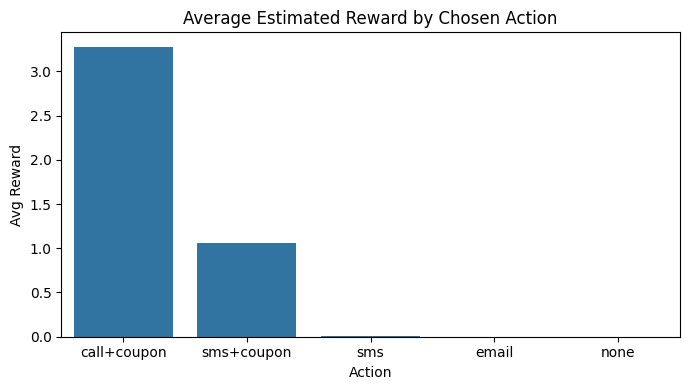

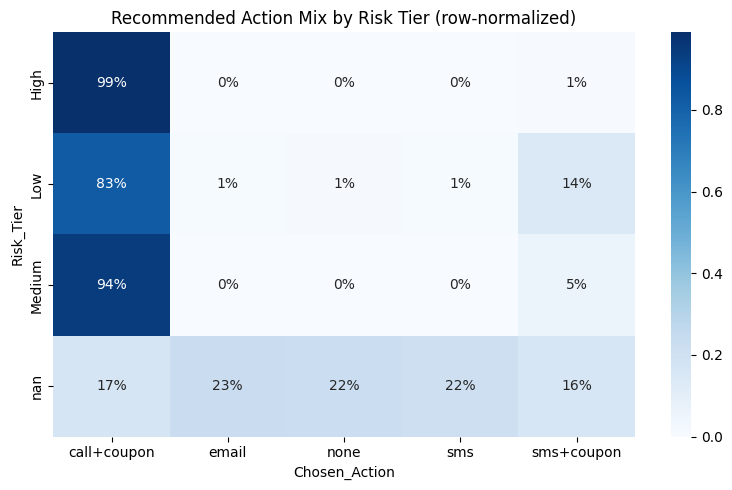

In [46]:
import numpy as npx
import pandas as pd

# ---- make a working copy ----
id_col = "customerid" # Use lowercase id_col
cx2 = cx.copy()

# ---------- Reward engineering ----------
# Base signal from action priors
cx2["ev_per_customer"] = pd.to_numeric(cx2["ev_per_customer"], errors="coerce").fillna(0.0) # Use lowercase column name

# Risk/Churn weight
risk_weight_map = {"high": 1.2, "medium": 1.0, "low": 0.6} # Use lowercase keys
if "churn_prob" in cx2.columns: # Use lowercase column name
    churn_factor = pd.to_numeric(cx2["churn_prob"], errors="coerce").clip(0, 1).fillna(0.0) # Use lowercase column name
else:
    churn_factor = cx2.get("risk_tier", "medium").astype(str).str.lower().map(risk_weight_map).fillna(1.0) # Use lowercase column name and keys

# Value factor (customer monetary potential)
mon = pd.to_numeric(cx2.get("monetary", 1.0), errors="coerce").fillna(0.0) # Use lowercase column name
med = float(npx.nanmedian(mon)) if npx.isfinite(npx.nanmedian(mon)) else 1.0
value_factor = (mon / max(med, 1e-6)).clip(0.5, 2.0)

# Final engineered reward
cx2["reward"] = (cx2["ev_per_customer"] * churn_factor * value_factor).fillna(0.0) # Use lowercase column names

# ---------- Context features ----------
cat_cols = [c for c in ["risk_tier", "country"] if c in cx2.columns] # Use lowercase column names
num_cols = [c for c in ["recency", "frequency", "monetary", "avgbasketspend", "returnrate"] if c in cx2.columns] # Use lowercase column names

# stringify cats to be safe for get_dummies
for c in cat_cols:
    cx2[c] = cx2[c].astype(str)

X_raw = pd.get_dummies(cx2[cat_cols + num_cols], columns=cat_cols, drop_first=True)
X_raw = X_raw.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# add a bias term if you want (helps stability)
if "bias" not in X_raw.columns:
    X_raw["bias"] = 1.0

actions = sorted(cx2["action"].dropna().unique().tolist()) # Use lowercase column name
d = X_raw.shape[1]

# ---------- LinUCB (one decision per customer) ----------
alpha = 0.6
A = {a: npx.eye(d) for a in actions}          # d×d
b = {a: npx.zeros((d, 1)) for a in actions}   # d×1

decisions = []
grouped = cx2.groupby(id_col, sort=False)

for cust_id, grp in grouped:
    # same context across this customer's action rows -> take the first row's features
    idx0 = grp.index[0]
    x = X_raw.loc[idx0].to_numpy(dtype=float).reshape(-1, 1)

    # ensure finite values
    if not npx.isfinite(x).all():
        x = npx.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    # compute UCB score for each action
    scores = {}
    for a in actions:
        A_inv = npx.linalg.inv(A[a])
        theta = A_inv @ b[a]                        # d×1
        mean = float((theta.T @ x).item())          # scalar
        conf = float(npx.sqrt(float((x.T @ A_inv @ x).item())))
        scores[a] = mean + alpha * conf

    # choose best action
    a_star = max(scores, key=scores.get)

    # observed reward for chosen action (from engineered reward)
    r_series = grp.loc[grp["action"] == a_star, "reward"] # Use lowercase column names
    r = float(r_series.iloc[0]) if len(r_series) else 0.0

    # update LinUCB
    A[a_star] = A[a_star] + (x @ x.T)
    b[a_star] = b[a_star] + r * x

    # record decision
    row0 = grp.iloc[0]
    decisions.append({
        id_col: cust_id,
        "Risk_Tier": row0.get("risk_tier", npx.nan), # Use lowercase column name
        "Country": row0.get("country", npx.nan), # Use lowercase column name
        "Recency": row0.get("recency", npx.nan), # Use lowercase column name
        "Frequency": row0.get("frequency", npx.nan), # Use lowercase column name
        "Monetary": row0.get("monetary", npx.nan), # Use lowercase column name
        "Chosen_Action": a_star,
        "Chosen_Score": scores[a_star],
        "Estimated_Reward": r
    })

policy_recs = pd.DataFrame(decisions)

# ---------- Summaries & saves ----------
policy_summary = (
    policy_recs.groupby("Chosen_Action")
               .agg(Average_Reward=("Estimated_Reward","mean"),
                    Customers=("Estimated_Reward","count"))
               .sort_values("Average_Reward", ascending=False)
               .reset_index()
)

tier_action_mix = (
    policy_recs.groupby(["Risk_Tier","Chosen_Action"])
               .size().unstack(fill_value=0).sort_index()
)

policy_recs.to_csv("contextual_policy_recommendations.csv", index=False)
policy_summary.to_csv("contextual_policy_summary.csv", index=False)
tier_action_mix.to_csv("contextual_policy_tier_action_mix.csv")

print("✅ Done")
print(policy_summary)
print(tier_action_mix)
print("✅ Saved: contextual_policy_recommendations.csv, contextual_policy_summary.csv, contextual_policy_tier_action_mix.csv")

# charts
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.barplot(data=policy_summary, x="Chosen_Action", y="Average_Reward")
plt.title("Average Estimated Reward by Chosen Action")
plt.xlabel("Action"); plt.ylabel("Avg Reward"); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(tier_action_mix.div(tier_action_mix.sum(1), axis=0), annot=True, fmt=".0%", cmap="Blues")
plt.title("Recommended Action Mix by Risk Tier (row-normalized)"); plt.tight_layout()
plt.show()

# In 'contextual_policy_recommendations.csv' the column named ''Estimated_Reward' is our ROI projection.

**The LinUCB Contextual Bandit analysis resulted in a radically different and likely over-optimistic policy compared to the static Expected Value (EV) model. The model overwhelmingly recommends the most expensive action, call+coupon, for the vast majority of customers (2,818 out of 4,289), resulting in the highest average reward of 3.28 pounds. This preference for the high-cost action is likely due to the contextual learning favoring the action with the highest potential estimated gross margin, leading to an excessive concentration of the budget. Specifically, the model assigns call+coupon to almost all High and Medium Risk customers, neglecting the low-cost sms campaigns previously deemed optimal for efficiency, suggesting a need to re-evaluate the risk tolerance ($\alpha$ parameter) or the underlying reward structure to achieve a more balanced and cost-effective marketing mix.**


**The Average Estimated Reward clearly indicates that the call+coupon action is the most lucrative strategy, delivering the highest average return of approximately £3.28 per contacted customer. However, given that this action is the most expensive, this high average reward strongly suggests the LinUCB model over-allocated budget to this action, prioritizing maximum potential profit without sufficiently balancing the cost-effectiveness of cheaper alternatives like SMS.**

**The contextual bandit (LinUCB) model demonstrates a critical bias towards the most expensive action, call+coupon, recommending it for virtually $99\%$ of High-Risk and $94\%$ of Medium-Risk customers. This high concentration is financially risky, as it ignores the profitability of low-cost channels (like SMS/Email) and suggests that the model is selecting the action with the highest potential reward, not the optimal net Expected Value (EV), indicating its learning process needs tuning to better incorporate cost factors.**





For RAG Enabled Chatbot - check E-commerce_RAG_1.ipynb

Interactive DashBoard

In [47]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install cartopy
import cartopy

E: Package 'libfluidsynth1' has no installation candidate
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.0 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=e8ba1e9c56332c0d50aae4c80988fd9ceafa9a1dcbf106150260a308edf29f74
  Stored in directory: /root/.cache/pip/wheels/29/20/ab/f101da7b245b996aa097685ef742243725ea6150f5b3b6d9ed
Successfully built libarchive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.2 MB/s eta 0:00:00


In [48]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 28.9 MB/s eta 0:00:00
